# Итоговый проект. Бриф “Агентство недвижимости”

К вам обратился представитель крупного агентства недвижимости со
следующей проблемой:

«Мои риелторы тратят катастрофически много времени на сортировку
объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да
и, сказать по правде, качество анализа не дотягивают до уровня конкурентов.
Это сказывается на наших финансовых показателях.


Ваша задача — разработать модель, которая позволила бы обойти
конкурентов по скорости и качеству совершения сделок. Вот датасет для
работы».


Что необходимо сделать: разработать сервис для предсказания стоимости
домов на основе истории предложений.

# Знакомство с данными

Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import hyperopt
import optuna
import pickle
import warnings
from hyperopt import hp, fmin, tpe, Trials
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from collections import Counter
from scipy.stats import normaltest
from scipy.stats import t
from ast import literal_eval

%matplotlib inline
plt.style.use('seaborn')

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.

Для начала давайте познакомимся с нашими данными:

In [47]:
data = pd.read_csv('drive/MyDrive/real_estate_data.csv')
data.head(1)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"


In [ ]:
# проверяем типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Итак, у нас есть данные о почти 400 000 объектах недвижимости. Каждый из них описывается следующими признаками:
* status - статус продажи
* private pool - наличие частного бассейна
* propertyType - тип недвижимости, поместья, свойства
* street - адрес дома
* baths - количество ванных комнат
* homeFacts - сведения о строении дома, содержит несколько отдельных данных
* fireplace - сведения о наличии камина в доме
* city - город
* schools - сведения о школах в районе
* sqft - площадь дома в футах
* zipcode - почтовый индекс
* beds - количество спален в доме
* state - государство/штаты
* stories - этажность недвижимости
* mls-id - идентификатор MLS (Multiple Listing Service - Служба множественного листинга)
* PrivatePool - наличие частного бассейна
* MlsId - идентификатор MLS (Multiple Listing Service - Служба множественного листинга)
* target - целевой признак, который необходимо спрогнозировать - цена недвижимости

In [ ]:
data.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


Посмотрим на содержание пропусков в данных.

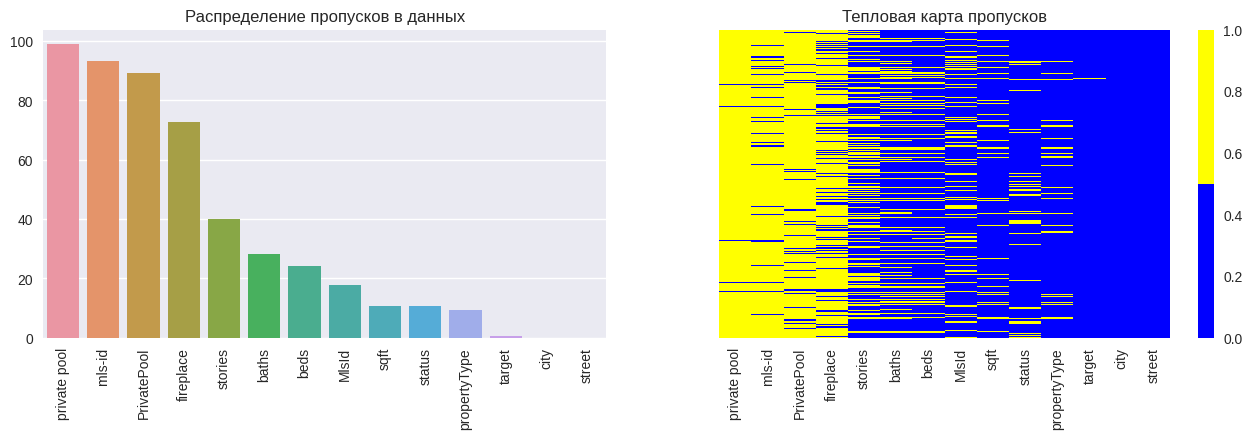

In [ ]:
# выделяем столбцы в которых пропусков больше нуля
cols_null_percent = data.isnull().mean() * 100
cols_with_null = (
    cols_null_percent[cols_null_percent>0]
    .sort_values(ascending=False)
)

# визуализируем данные
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
colors = ['blue', 'yellow']
cols = cols_with_null.index

barplot = sns.barplot(x=cols, y=cols_with_null, ax=axes[0])
barplot.set_title('Распределение пропусков в данных')
barplot.xaxis.set_tick_params(rotation=90)

heatmap = sns.heatmap(
    data[cols].isnull(),
    cmap=sns.color_palette(colors),
    yticklabels=False,
    ax=axes[1]
)
heatmap.set_title('Тепловая карта пропусков');

Целевой признак содержит не более 1 процента пропусков. Пожалуй, можно удалить эти объекты из датасета.

In [48]:
data = data[~data['target'].isna()]

Преобразуем целевой признак в числовой.

In [49]:
data['target'] = data['target'].apply(lambda x: (
    x
    .split(' - ')[0] # если указан диапазон, берём только первую цену
    .replace('$', '')
    .replace(',', '')
    .replace('+', '')
    .replace('/mo', '') # цена за месяц (аренда)
)).astype('int')

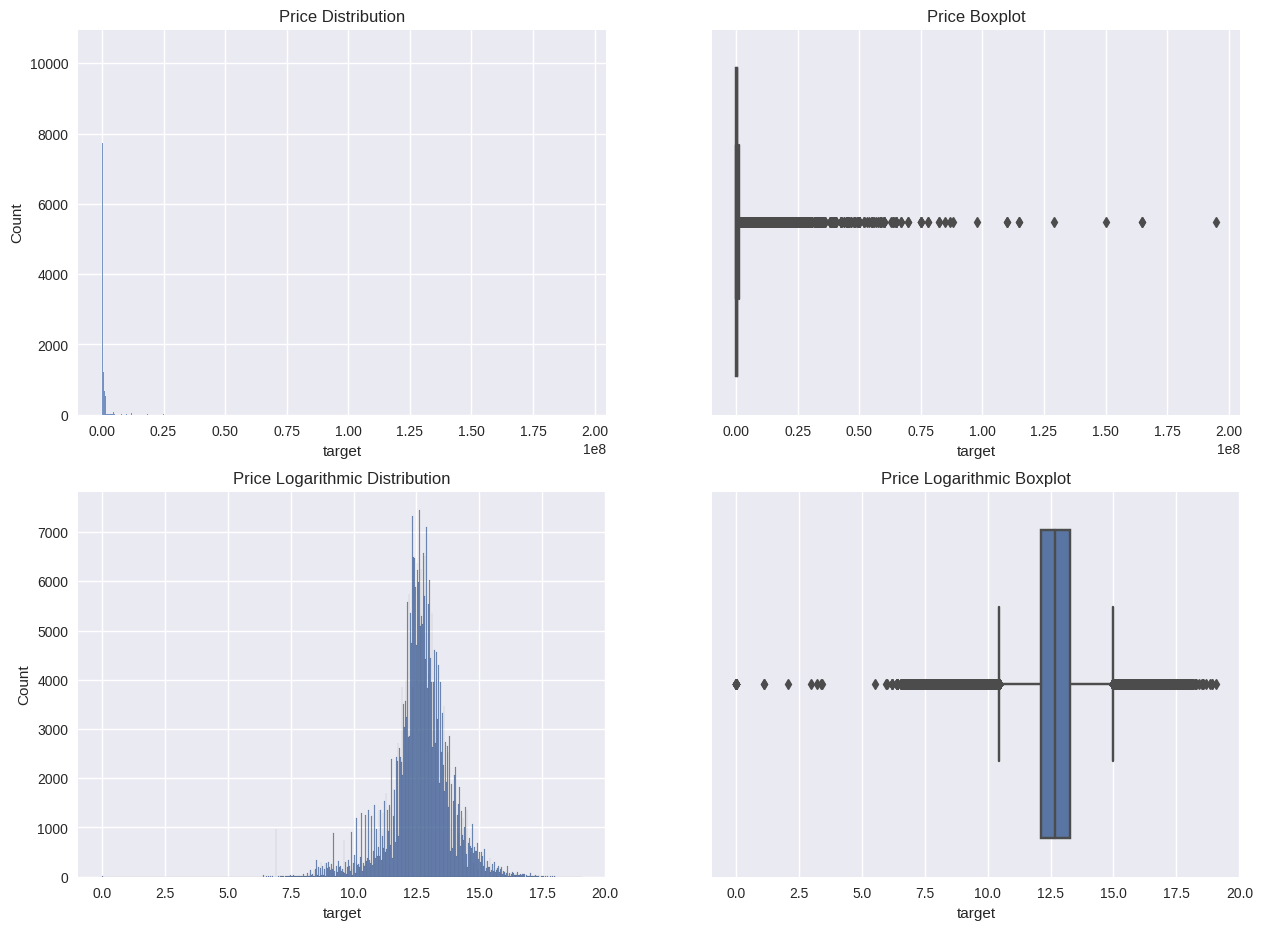

In [ ]:
# посмотрим на распределение целевого признака
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

histplot = sns.histplot(x=data['target'], ax=axes[0][0])
histplot.set_title('Price Distribution')
boxplot = sns.boxplot(x=data['target'], ax=axes[0][1])
boxplot.set_title('Price Boxplot')

histplot_log = sns.histplot(x=np.log(data['target']), ax=axes[1][0])
histplot_log.set_title('Price Logarithmic Distribution')
boxplot_log = sns.boxplot(x=np.log(data['target']), ax=axes[1][1])
boxplot_log.set_title('Price Logarithmic Boxplot');

Проверим полученнное логорифмическое распределение на нормальность.

In [ ]:
# формируем нулевую и альтернативную гипотезы
H0 = 'Данные распределены нормально.'
Ha = 'Распределение отлично от нормального.'

# устанавливаем уровень значимости
alpha = 0.05

# тест Д'Агостино (возвращает двустороннюю вероятность для проверки гипотезы)
_, p = normaltest(np.log(data['target']))
print(f'P-value = {round(p, 2)}')

# интерпритация полученного результата,
# p-value рассчитано для двусторонней гипотезы,
# поэтому уровень значимости делим на 2
if p > alpha / 2:
    print(H0)
else:
    print(Ha)

P-value = 0.0
Распределение отлично от нормального.


Посмотрим на распределение стоимости недвижимости в зависимости от штата для объектов до 25 млн.

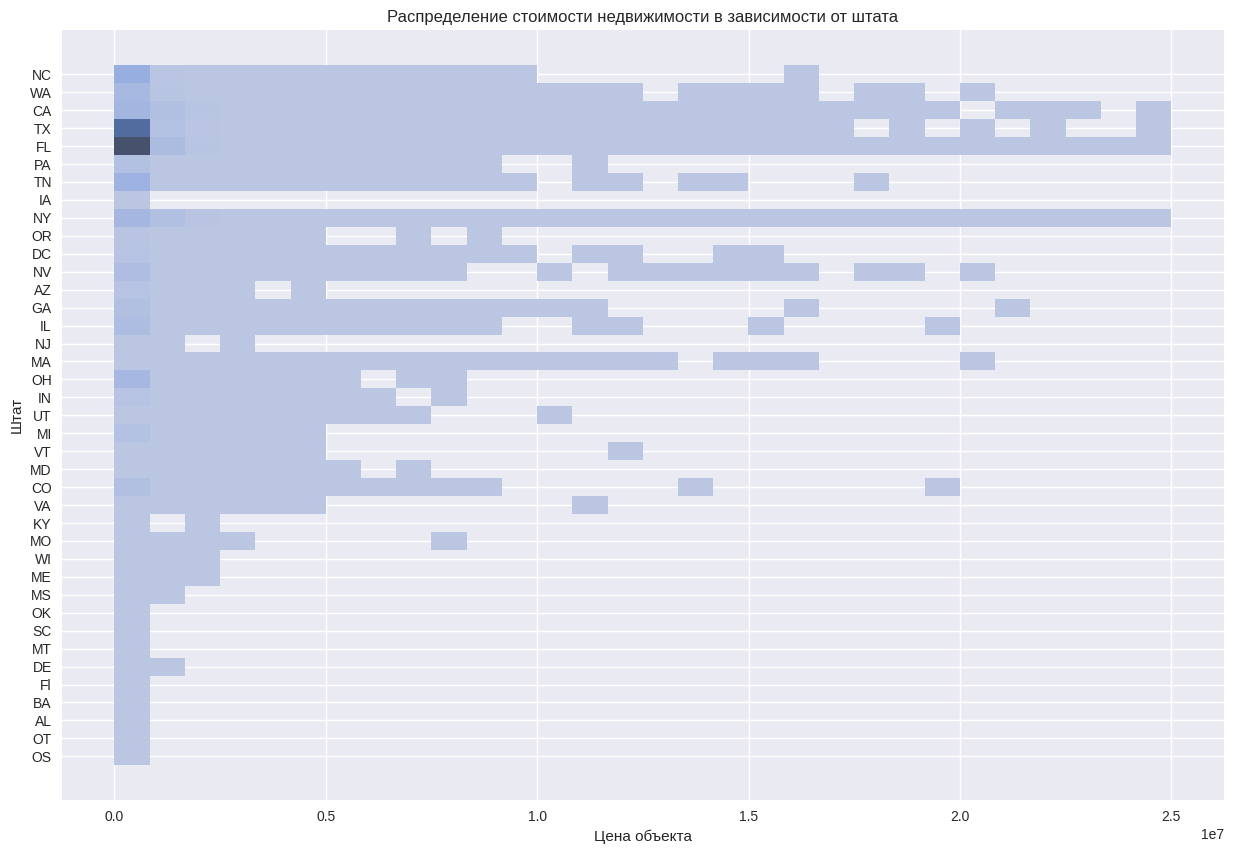

In [ ]:
fig = plt.figure(figsize=(15, 10))

histplot = sns.histplot(
    data=data[data['target'] < 25000000],
    x='target',
    y='state',
    bins=30
)
histplot.set_title(
    'Распределение стоимости недвижимости в зависимости от штата'
)
histplot.set_xlabel('Цена объекта')
histplot.set_ylabel('Штат');

Основная часть цен на объекты сосредоточена в интервале до 1 млн. Далее при повышении цены количество объектов только падает, что вполне соответствует жизненным реалиям — дорогих и роскошных домов гораздо меньше, чем домов среднего ценового сегмента.

Cтоимость объектов достигает 25 млн только в штатах: Калифорния, Техас, Флорида и Нью-Йорк.

Большая часть объектов находится в шатах Флорида и Техас.

Посмотрим на содержание колонки 'homeFacts', предварительно преобразовав информацию в словарь с помощью функции literal_eval библиотеки ast.

In [50]:
# образец, структура списка со словарями сохраняется для всех индексов
structure = literal_eval(data['homeFacts'].iloc[0])['atAGlanceFacts']
structure

[{'factValue': '2019', 'factLabel': 'Year built'},
 {'factValue': '', 'factLabel': 'Remodeled year'},
 {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'},
 {'factValue': '', 'factLabel': 'Cooling'},
 {'factValue': '', 'factLabel': 'Parking'},
 {'factValue': None, 'factLabel': 'lotsize'},
 {'factValue': '$144', 'factLabel': 'Price/sqft'}]

Создадим отдельный признак для каждого словаря из списка.

In [51]:
%%time

# распаковываем словари
for i, fact in enumerate(structure):
    data[fact['factLabel']] = (
        data['homeFacts']
        .apply(lambda x: literal_eval(x)['atAGlanceFacts'][i]['factValue'])
        .replace('', np.NaN) # заменяем скрытые пропуски на np.NaN
        .replace('—', np.NaN)
        .replace('No Data', np.NaN)
        .replace('None', np.NaN)
        .replace('No Info', np.NaN)
        .replace('-- sqft lot', np.NaN)
    )
data = data.drop('homeFacts', axis=1)

CPU times: user 3min 24s, sys: 588 ms, total: 3min 25s
Wall time: 3min 25s


Посмотрим на содержание колонки 'schools', предварительно преобразовав информацию в словарь с помощью функции literal_eval библиотеки ast.

In [52]:
# образец, структура списка со словарями сохраняется для всех индексов
structure = literal_eval(data['schools'].iloc[0])
structure

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'],
  'data': {'Distance': ['2.7 mi',
    '3.6 mi',
    '5.1 mi',
    '4.0 mi',
    '10.5 mi',
    '12.6 mi',
    '2.7 mi',
    '3.1 mi'],
   'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']},
  'name': ['Southern Pines Elementary School',
   'Southern Middle School',
   'Pinecrest High School',
   'Southern Pines Primary School',
   "Crain's Creek Middle School",
   'Union Pines High School',
   'Episcopal Day Private School',
   'Calvary Christian Private School']}]

In [53]:
%%time

# распаковываем словари
data['schools_rating'] = (
    data['schools']
    .apply(lambda x: literal_eval(x)[0]['rating'])
)
data['schools_distance'] = (
    data['schools']
    .apply(lambda x: literal_eval(x)[0]['data']['Distance'])
)
data['schools_grades'] = (
    data['schools']
    .apply(lambda x: literal_eval(x)[0]['data']['Grades'])
)
data['schools_name'] = (
    data['schools'].apply(lambda x: literal_eval(x)[0]['name'])
)
data = data.drop('schools', axis=1)

CPU times: user 1min 31s, sys: 1.35 s, total: 1min 32s
Wall time: 1min 32s


Для чистоты экспериментов сразу разделим выборку на тренировочную и тестовую.

In [54]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Анализ данных

Создадим вспомогательные функции для обработки данных.

In [ ]:
def t_mean_conf_interval(x_mean, x_std, n, gamma=0.95):
    """
    Функция для вычисления доверительного интервала для среднего.

    Args:
        x_mean: выборочное среднее
        x_std: выборочное стандартное отклонение
        n: размер выборки
        gamma: уровень надёжности (по умолчанию 95 %)
    Returns:
        (lower_bound, upper_bound): кортеж из границ доверительного интервала
    """
    k = n - 1                         # число степеней свободы
    alpha = 1 - gamma                 # уровень значимости
    t_crit = -t.ppf(alpha/2, k)       # t-критическое
    eps = t_crit * x_std / (n ** 0.5) # погрешность
    lower_bound = x_mean - eps        # левая (нижняя) граница
    upper_bound = x_mean + eps        # правая (верхняя) граница

    # возвращаем кортеж из границ интервала
    return (lower_bound, upper_bound)

In [ ]:
def create_categorical_feats(data, col_name, iter_set, info_level=0.05,
                             just_words=False, list_in_value=False, gamma=0.95):
    """
    Функция создаёт колонки-индикаторы из значений категориальных признаков.
    Функция оставляет только информативные колонки, то есть только те,
    модальное значение в которых не ниже и не выше заданного уровня
    информативности. Также функция проверяет не пересекаются ли границы
    доверительных интервалов для среднего значения целевого признака.

    Args:
        data: набор данных
        col_name: название колонки
        iter_set: список значений для перебора
        info_level: уровень информативности нового признака
                    (по умолчанию 5 %)
        just_words: в случае когда надо проверить вхождение слова в значение
                    (по умолчанию False)
        list_in_values: в случае когда в значении у нас список строк
                    (по умолчанию False)
        gamma: уровень надёжности для доверительного интервала

    Функция выводит на экран список потенциальных колонок.
    """
    for value in iter_set:
        if just_words:
            data[value] = (
                data[col_name]
                .apply(lambda x: 1 if value in str(x).split(' ') else 0)
                .astype('int8')
            )
        elif list_in_value:
            data[value] = (
                data[col_name]
                .apply(lambda x: 1 if value in x else 0)
                .astype('int8')
            )
        else:
            data[value] = (
                data[col_name]
                .apply(lambda x: 1 if x == value else 0)
                .astype('int8')
            )
        # удаляем признак если он не информативен
        if ((data[value].mean() > 1-info_level)
        or (data[value].mean() < info_level)):
            data = data.drop(value, axis=1)
            continue
        # вычисляем доверительные интервалы для 2-ух случаев
        bounders_0 = t_mean_conf_interval(
            data[data[value] == 0]['target'].mean(),
            data[data[value] == 0]['target'].std(),
            data[data[value] == 0].shape[0],
            gamma=gamma
        )
        bounders_1 = t_mean_conf_interval(
            data[data[value] == 1]['target'].mean(),
            data[data[value] == 1]['target'].std(),
            data[data[value] == 1].shape[0],
            gamma=gamma
        )
        # если интервалы пересекаются, удаляем признак
        if bounders_0[0] < bounders_1[0]:
            if bounders_0[1] > bounders_1[0]:
                data = data.drop(value, axis=1)
                continue
        else:
            if bounders_1[1] > bounders_0[0]:
                data = data.drop(value, axis=1)
                continue

    # убираем признаки с dtypes "object"
    object_columns = [s for s in data.columns if data[s].dtypes == 'object']
    data.drop(object_columns, axis = 1, inplace = True)
    print('Потенциальные признаки:', list(data.drop('target', axis=1).columns))

### Анализ признака 'status'

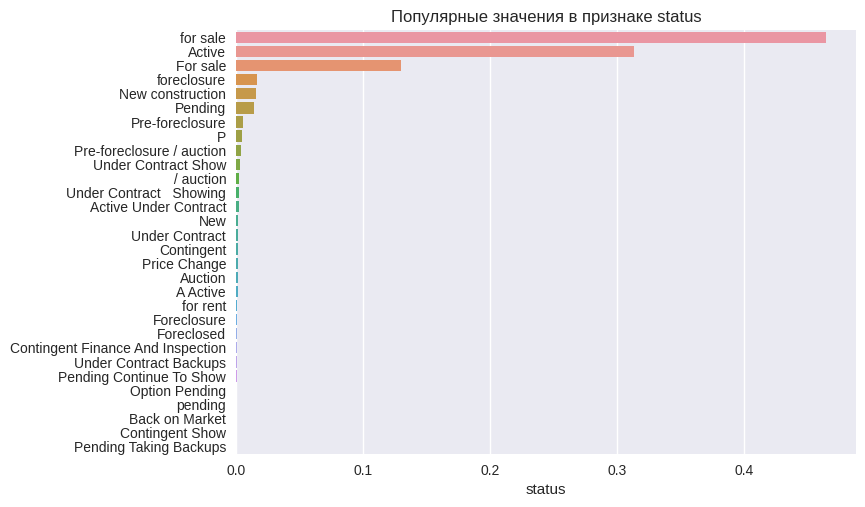

In [ ]:
# посмотрим на топ популярных признаков
top_values = train_data['status'].value_counts(normalize=True)[:30]
fig = plt.figure()
barplot = sns.barplot(x=top_values, y=top_values.index)
barplot.set_title('Популярные значения в признаке status');

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
create_categorical_feats(
    data=train_data.copy(),
    col_name='status',
    iter_set=top_values.index
)

Потенциальные признаки: ['For sale']


Из признака 'status' выделим 1 колонку: for_sale (на продажу).

### Анализ признака 'propertyType'

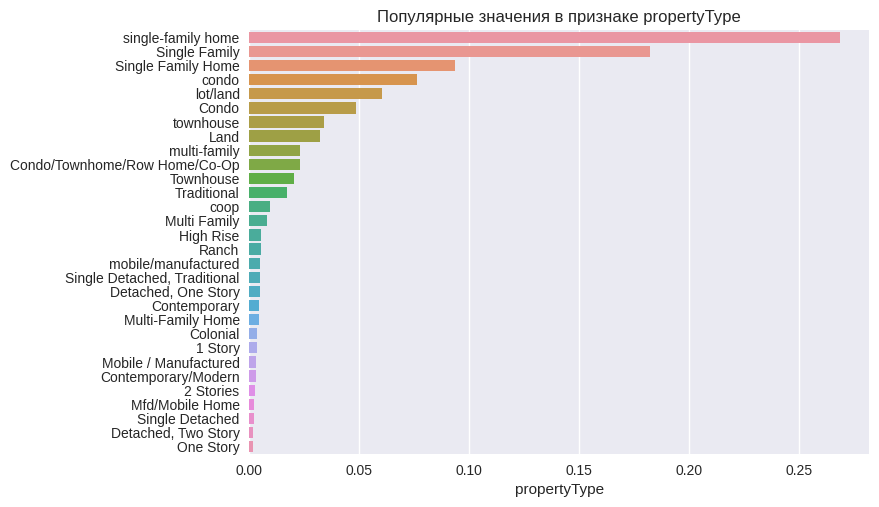

In [ ]:
# посмотрим на топ популярных признаков
top_values = train_data['propertyType'].value_counts(normalize=True)[:30]
fig = plt.figure()
barplot = sns.barplot(x=top_values, y=top_values.index)
barplot.set_title('Популярные значения в признаке propertyType');

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
create_categorical_feats(
    data=train_data.copy(),
    col_name='propertyType',
    iter_set=top_values.index,
    info_level = 0.03
)

Потенциальные признаки: ['single-family home', 'Single Family', 'Single Family Home', 'condo', 'lot/land', 'Condo', 'townhouse']


Из признака 'propertyType' выделим 3 колонки:

- single_family (частный дом),
- condo (кондоминимум),
- land (земельный участок),
- townhouse (рядный дом).

### Анализ признака 'street'

In [ ]:
# поищем наиболее полезные слова в названиях улиц
words = []
for street in train_data['street'].values:
    words.extend(str(street).split(' '))

# создаём объект Counter и передаём в него полученные слова для подсчёта
word_counts = Counter(words)

# с помощью метода most_common() извлекаем наиболее популярные слова
popular_streets = word_counts.most_common()[:30]
popular_streets[:10]

[('St', 65955),
 ('Dr', 51392),
 ('Ave', 49507),
 ('', 48784),
 ('Rd', 25924),
 ('Ln', 18178),
 ('N', 14831),
 ('W', 14466),
 ('Ct', 14113),
 ('S', 14022)]

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
word_list = []
for word in popular_streets:
    word_list.append(word[0])

create_categorical_feats(
    data=train_data.copy(),
    col_name='street',
    iter_set=word_list,
    just_words=True,
    info_level=0.03
)

Потенциальные признаки: ['St', 'Dr', '', 'Ln', 'W', 'Ct', 'SW', 'E', 'NW', 'Blvd']


Создадим категории значимых:
- типов улиц (St, Dr, Ln, Ct, Blvd) и
- регионов (W, SW, E, NW).

### Анализ признака 'baths'

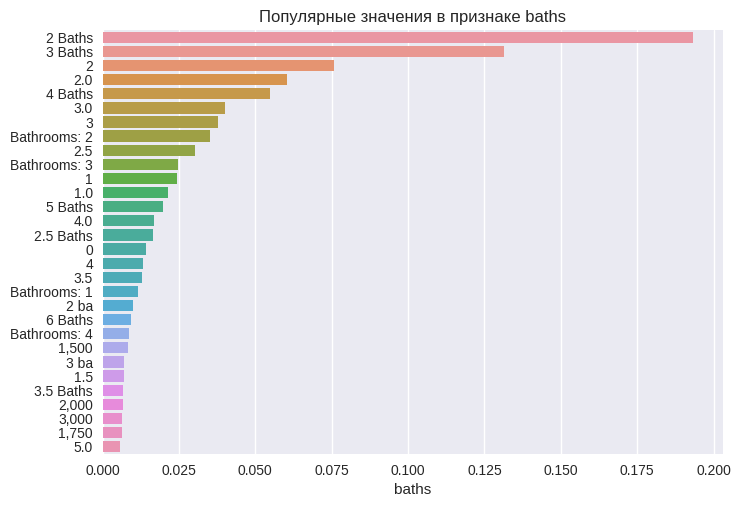

In [ ]:
# посмотрим на топ популярных признаков
top_values = train_data['baths'].value_counts(normalize=True)[:30]
fig = plt.figure()
barplot = sns.barplot(x=top_values, y=top_values.index)
barplot.set_title('Популярные значения в признаке baths');

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
create_categorical_feats(
    data=train_data.copy(),
    col_name='baths',
    iter_set=top_values.index,
    info_level = 0.03
)

Потенциальные признаки: ['2 Baths', '3 Baths', '2', '2.0', '4 Baths']


Извлечём из колонки 'baths' числа и создадим числовой признак. Пропуски заполним медианным значением на тренировочной выборке - 2.5.

### Анализ признаков 'Year built' и 'Remodeled year'.

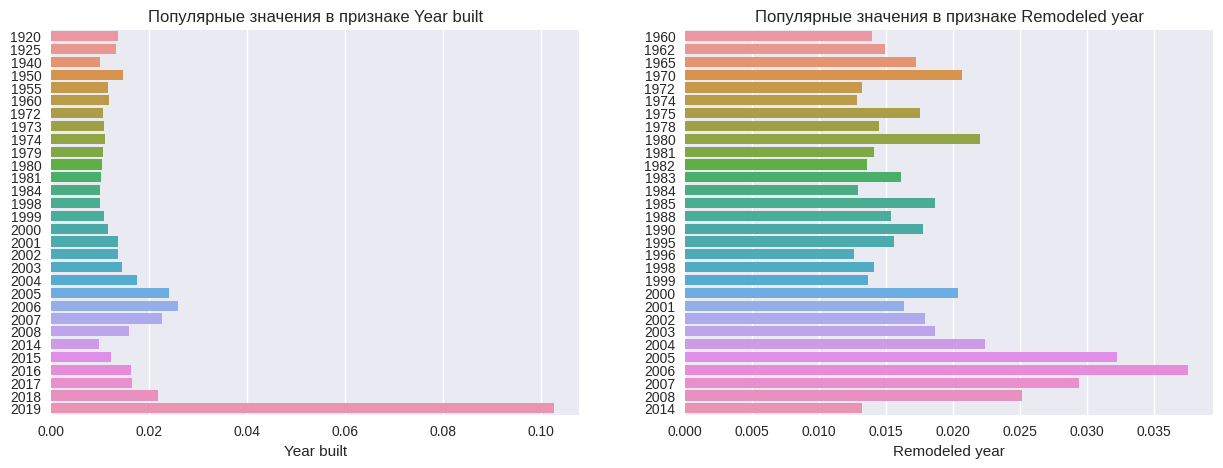

In [ ]:
# посмотрим на топ популярных признаков
top_built = (
    train_data['Year built']
    .value_counts(normalize=True)[:30]
    .sort_index()
)
top_remodeled = (
    train_data['Remodeled year']
    .value_counts(normalize=True)[:30]
    .sort_index()
)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=top_built, y=top_built.index, ax=ax[0])
sns.barplot(x=top_remodeled, y=top_remodeled.index, ax=ax[1])
ax[0].set_title('Популярные значения в признаке Year built');
ax[1].set_title('Популярные значения в признаке Remodeled year');

Пропуски в признаке 'Year built' заполним значениями из признака 'Remodeled year' и оставшиеся пропуски заполним медианным значением года постройки - 1985.

Дополнительно из признака 'Remodeled year' создадим колонку-индикатор 'remodeled' означающее было ли здание реконструировано.

### Анализ признака 'Heating'

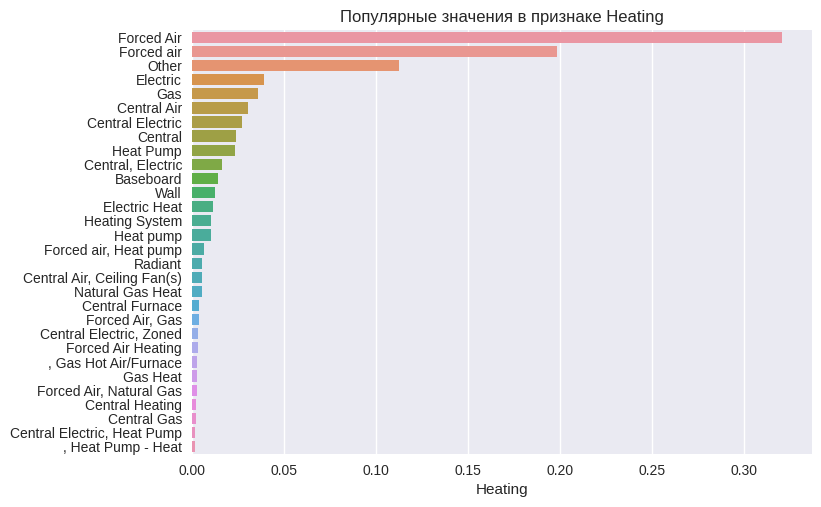

In [ ]:
# посмотрим на топ популярных признаков
top_values = train_data['Heating'].value_counts(normalize=True)[:30]
fig = plt.figure()
barplot = sns.barplot(x=top_values, y=top_values.index)
barplot.set_title('Популярные значения в признаке Heating');

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
create_categorical_feats(
    data=train_data.copy(),
    col_name='Heating',
    iter_set=top_values.index
)

Потенциальные признаки: ['Forced Air', 'Forced air', 'Other']


Из признака 'Heating' выделим 2 колонки:
- forced_air (тип центрального отопления, наиболее часто устанавливаемый в Северной Америке),
- other_heating (остальные, не содержащие пропуски).

### Анализ признака 'Cooling'

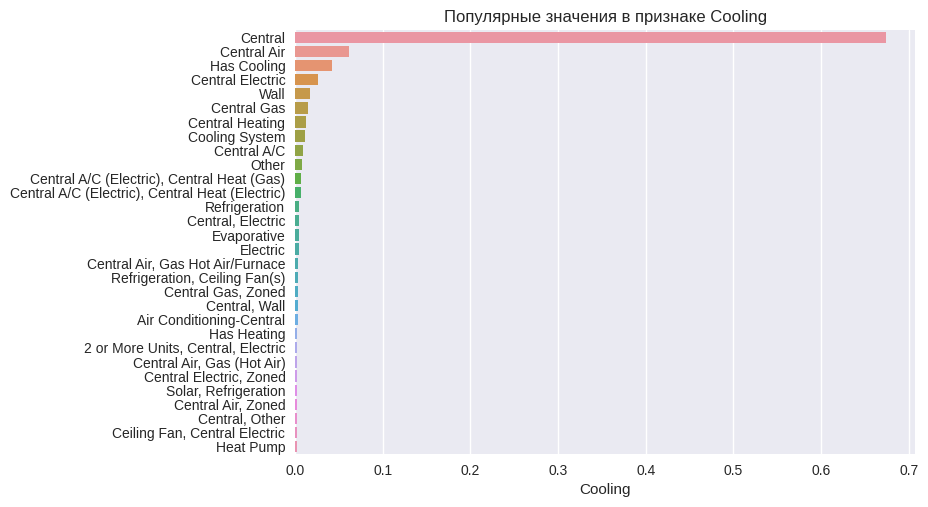

In [ ]:
# посмотрим на топ популярных признаков
top_values = train_data['Cooling'].value_counts(normalize=True)[:30]
fig = plt.figure()
barplot = sns.barplot(x=top_values, y=top_values.index)
barplot.set_title('Популярные значения в признаке Cooling');

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
create_categorical_feats(
    data=train_data.copy(),
    col_name='Cooling',
    iter_set=top_values.index,
    info_level=0.03
)

Потенциальные признаки: ['Central', 'Central Air']


Из признака 'Cooling' выделим 1 колонку: central_cooling (центральное охлаждение).

### Анализ признака 'Parking'

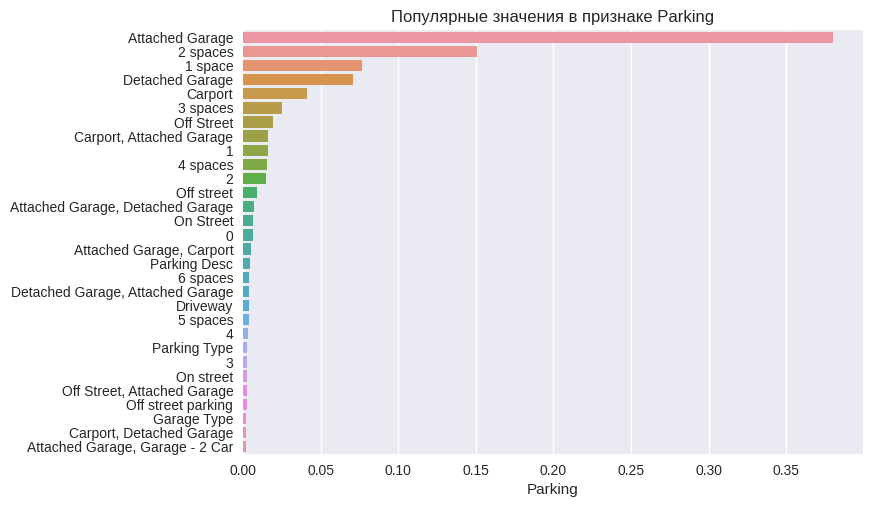

In [ ]:
# посмотрим на топ популярных признаков
top_values = train_data['Parking'].value_counts(normalize=True)[:30]
fig = plt.figure()
barplot = sns.barplot(x=top_values, y=top_values.index)
barplot.set_title('Популярные значения в признаке Parking');

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
create_categorical_feats(
    data=train_data.copy(),
    col_name='Parking',
    iter_set=top_values.index,
    info_level=0.03
)

Потенциальные признаки: ['Attached Garage', '2 spaces', '1 space', 'Detached Garage']


In [ ]:
# количество пропусков
train_data['Parking'].isna().mean()

0.506446759606756

Извлечём из колонки 'Parking' числа и создадим числовой признак. Пропуски заполним 0 (будем считать, что отсутствие значения означает отсутствие парковки). Значения не содержащие чисел заполним 1.

Дополнительно создадим колонки:
- attached_garage (пристроенный гараж),
- detached_garage (отдельно стоящий гараж).

### Анализ признака 'lotsize'

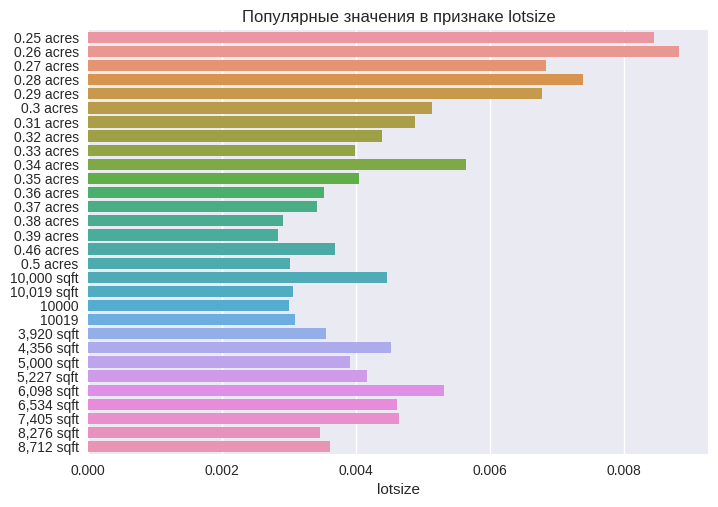

In [ ]:
# посмотрим на топ популярных признаков
top_values = (
    train_data['lotsize']
    .value_counts(normalize=True)[:30]
    .sort_index()
)
fig = plt.figure()
barplot = sns.barplot(x=top_values, y=top_values.index)
barplot.set_title('Популярные значения в признаке lotsize');

Извлечём из колонки 'lotsize' числа, кв. футы разделим на 43560 и создадим числовой признак. Пропуски заполним медианным значением на тренировочной выборке - 0.19 акров.

### Анализ признака 'fireplace'

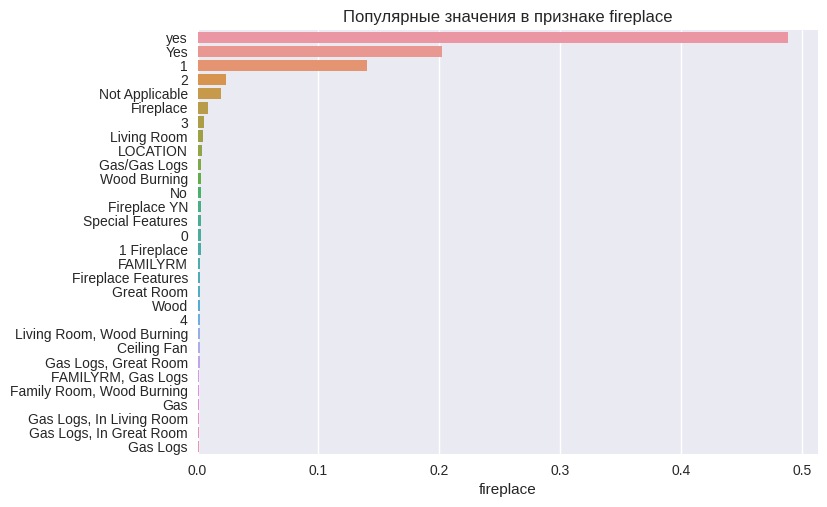

In [ ]:
# посмотрим на топ популярных признаков
top_values = train_data['fireplace'].value_counts(normalize=True)[:30]
fig = plt.figure()
barplot = sns.barplot(x=top_values, y=top_values.index)
barplot.set_title('Популярные значения в признаке fireplace');

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
create_categorical_feats(
    data=train_data.copy(),
    col_name='fireplace',
    iter_set=top_values.index,
    info_level=0.03,
    gamma=0.93
)

Потенциальные признаки: ['yes', 'Yes', '1']


In [ ]:
# количество пропусков
train_data['fireplace'].isna().mean()

0.7268542148297155

В признаке 'fireplace' заполним пропуски нулями (будем воспринимать отсутствие значения как отсутствие камина). Из остальных значений извлечём числа. Значения не содержащие чисел заполним 1.

### Анализ признака 'city'

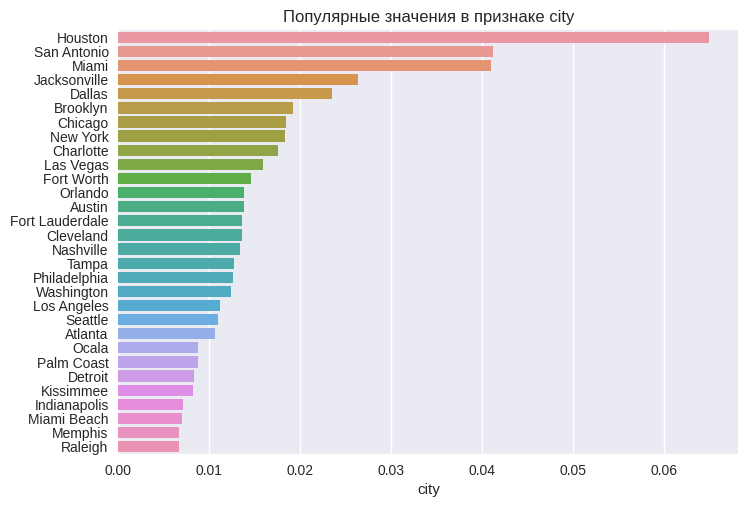

In [ ]:
# посмотрим на топ популярных признаков
top_values = train_data['city'].value_counts(normalize=True)[:30]
fig = plt.figure()
barplot = sns.barplot(x=top_values, y=top_values.index)
barplot.set_title('Популярные значения в признаке city');

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
create_categorical_feats(
    data=train_data.copy(),
    col_name='city',
    iter_set=top_values.index,
    info_level=0.04
)

Потенциальные признаки: ['Houston', 'San Antonio', 'Miami']


Создадим признаки значимых городов: Houston, San Antonio, Miami.

### Анализ признака 'schools_rating'

In [ ]:
# посмотрим что хранится в признаке
train_data['schools_rating'][:10]

263698                      [5/10, 7/10, 6/10]
335858                            [8/10, 3/10]
49951            [8, 3, 10, 10, 8, NR, NR, NR]
50323                    [3/10, 2/10, None/10]
10819                       [4/10, 4/10, 3/10]
267873              [7, 8, 8, 7, 1, 4, NR, NR]
18505                                       []
323052                      [6/10, 7/10, 6/10]
105084                      [4/10, 7/10, 6/10]
317231    [6/10, 8/10, 6/10, 5/10, 7/10, 2/10]
Name: schools_rating, dtype: object

Извлечём оценки и заменим значение в признаке на среднее. Пропуски заполним медианным значением на тренировочной выборке - 5.

### Анализ признака 'schools_distance'

In [ ]:
# посмотрим что хранится в признаке
train_data['schools_distance'][:10]

263698                               [2.7mi, 7.3mi, 3.33mi]
335858                                     [0.48mi, 1.15mi]
49951     [0.6 mi, 2.2 mi, 0.4 mi, 1.2 mi, 1.4 mi, 0.7 m...
50323                              [0.25mi, 1.46mi, 1.14mi]
10819                              [0.6 mi, 2.9 mi, 4.2 mi]
267873    [0.4 mi, 1.0 mi, 1.5 mi, 1.0 mi, 1.0 mi, 2.0 m...
18505                                                    []
323052                             [0.93mi, 0.83mi, 0.41mi]
105084                             [1.1 mi, 0.5 mi, 0.6 mi]
317231    [0.94mi, 1.81mi, 1.46mi, 5.14mi, 6.78mi, 19.76mi]
Name: schools_distance, dtype: object

Извлечём расстояния и заменим значение в признаке на среднее. Пропуски заполним медианным значением на тренировочной выборке - 1.78 мили.

### Анализ признака 'schools_grades'

In [ ]:
# посмотрим что хранится в признаке
train_data['schools_grades'][:10]

263698                                  [9-12, PK-6, 7-8]
335858                                       [PK-8, 6-12]
49951     [PK–8, 6–12, 9–12, PK–5, 6–8, 9–12, PK–8, K–12]
50323                                   [9-12, PK-5, 6-8]
10819                                   [PK-5, 6-8, 9-12]
267873     [K–5, 6–8, 9–12, PK–5, 7–12, 9–12, 9–12, PK–8]
18505                                                  []
323052                                   [7-9, 9-12, K-6]
105084                                   [K-5, 6-8, 9-12]
317231                [6-8, PK-5, PK-5, 9-12, PK-5, 9-12]
Name: schools_grades, dtype: object

In [ ]:
# поищем наиболее полезные градации школ
grades = []
for grade in train_data['schools_grades'].values:
    grades.extend(grade)

# создаём объект Counter и передаём в него полученные градации для подсчёта
grades_counts = Counter(grades)

# с помощью метода most_common() извлекаем наиболее популярные градации
popular_grades = grades_counts.most_common()[:30]
popular_grades[:10]

[('9-12', 211951),
 ('PK-5', 164665),
 ('6-8', 158692),
 ('9–12', 66796),
 ('PK-8', 60396),
 ('9 to 12', 50596),
 ('6 to 8', 47143),
 ('6–8', 37768),
 ('Preschool to 5', 36687),
 ('K-5', 33123)]

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
grades_list = []
for grade in popular_grades:
    grades_list.append(grade[0])

create_categorical_feats(
    data=train_data.copy(),
    col_name='schools_grades',
    iter_set=grades_list,
    list_in_value=True,
    info_level=0.03
)

Потенциальные признаки: ['PK-5', '6-8', '9–12', 'PK-8', '9 to 12', '6 to 8', '6–8', 'Preschool to 5', 'K-5', 'PK–5', 'PK–8', 'K-8', 'Preschool to 8', 'K–5', '7-8', 'K–8', 'PK–12', 'K–12', 'PK-6']


Из признака 'schools_grades' выделим 7 колонок:

- pk_5 (от детского сада до 5 класса),
- pk_6 (от детского сада до 6 класса),
- pk_8 (от детского сада до 8 класса),
- pk_12 (от детского сада до 12 класса),
- 6_8 (от 6 до 8 класса),
- 7_8 (от 7 до 8 класса),
- 9_12 (от 9 до 12 класса).

### Анализ признака 'schools_name'

In [ ]:
# посмотрим что хранится в признаке
train_data['schools_name'][:10]

263698    [Matanzas High School, Old Kings Elementary Sc...
335858    [School Without Walls @ Francis-Stevens, Cardo...
49951     [School Without Walls @ Francis-Stevens, Cardo...
50323     [Bonanza High School, Doris Hancock Elementary...
10819     [Harris Creek Elementary, Rolesville Middle Sc...
267873    [Garrett Park Elementary School, Tilden Middle...
18505                                                    []
323052    [Fairview Junior High School, Olympic High Sch...
105084    [Mccornack Elementary School, Kennedy Middle S...
317231    [Bonita Springs Middle Center For The Arts, Bo...
Name: schools_name, dtype: object

In [ ]:
# поищем наиболее полезные названия школ
names = []
for name in train_data['schools_name'].values:
    names.extend(name)

# создаём объект Counter и передаём в него полученные названия для подсчёта
names_counts = Counter(names)

# с помощью метода most_common() извлекаем наиболее популярные названия
popular_names = names_counts.most_common()[:30]
popular_names[:10]

[('Air Base Elementary School', 20783),
 ('Robert Morgan Voc-Tech Institute', 12711),
 ('Hope College Prep High School', 4521),
 ('Booker T. Washington Senior High School', 4411),
 ('Nyc Lab High School For Collaborative Studies', 3552),
 ('Cornerstone Academy Charter', 3372),
 ('Cornerstone Charter Academy High School', 3372),
 ('Miami Beach Senior High School', 3027),
 ('Sunrise Middle School', 2981),
 ('Life Sciences Secondary School', 2979)]

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
names_list = []
for name in popular_names:
    names_list.append(name[0])

create_categorical_feats(
    data=train_data.copy(),
    col_name='schools_name',
    iter_set=names_list,
    list_in_value=True,
    info_level=0.04
)

Потенциальные признаки: ['Air Base Elementary School', 'Robert Morgan Voc-Tech Institute']


Из признака 'schools_name' выделим 2 колонки:

- abes (Air Base Elementary School)
- rmvti (Robert Morgan Voc-Tech Institute)

### Анализ признака 'Price/sqft' и 'sqft'

In [ ]:
# посмотрим на значения площади, стоимости за кв. фут и целевого признака
train_data[['sqft', 'Price/sqft', 'target']].head(10)

,sqft,Price/sqft,target
263698,"1,808 sqft",$166/sqft,299900
335858,"3,636 sqft",None,2089808
49951,1495,$512,765000
50323,"1,106 sqft",$144/sqft,158900
10819,"1,290 sqft",$153,197000
267873,3360,$356,1195000
18505,"1,417",$130 / Sq. Ft.,183900
323052,"1,296 sqft",$96/sqft,124900
105084,"Total interior livable area: 1,119 sqft",$96,106900
317231,"1,414 sqft",$155/sqft,219000


Признак 'Price/sqft' использовать не будем, так как он очень похож на утечку данных и в реальной жизни доступен не будет.

Извлечём из колонки 'sqft' числа и создадим числовой признак площади. Пропуски заполним медианным значением на тренировочной выборке - 1800.

### Анализ признака 'zipcode'

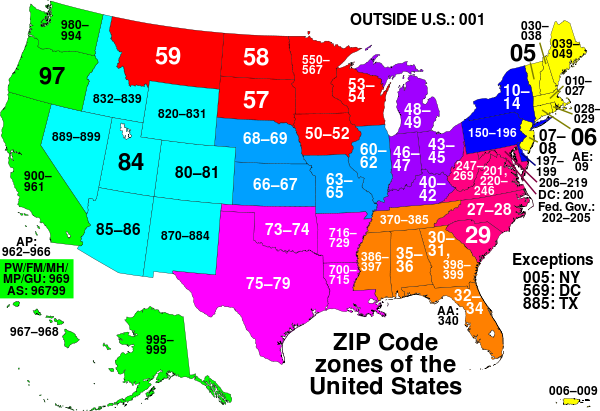

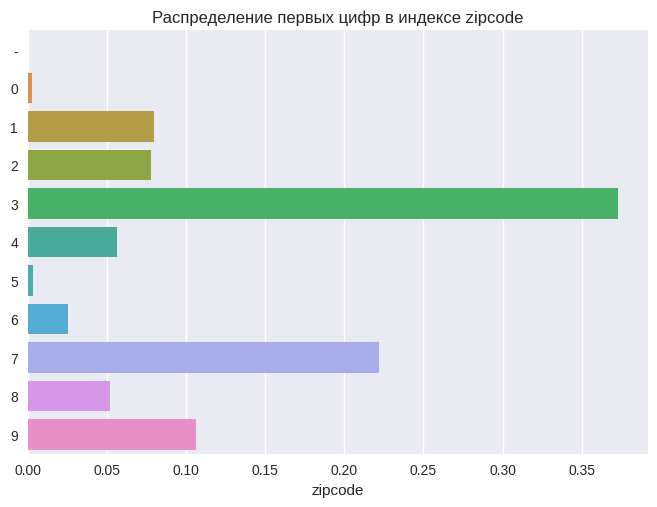

In [ ]:
# разделим почтовый индекс на категории - по первой цифре в коде
tmp_df = train_data.copy()
tmp_df['zipcode'] = tmp_df['zipcode'].apply(lambda x: x[0])

# посмотрим на распределение признаков
top_values = tmp_df['zipcode'].value_counts(normalize=True).sort_index()
fig = plt.figure()
barplot = sns.barplot(x=top_values, y=top_values.index)
barplot.set_title('Распределение первых цифр в индексе zipcode');

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
create_categorical_feats(
    data=tmp_df.copy(),
    col_name='zipcode',
    iter_set=top_values.index
)

Потенциальные признаки: ['1', '2', '3', '4', '7', '8', '9']


### Анализ признака 'beds'

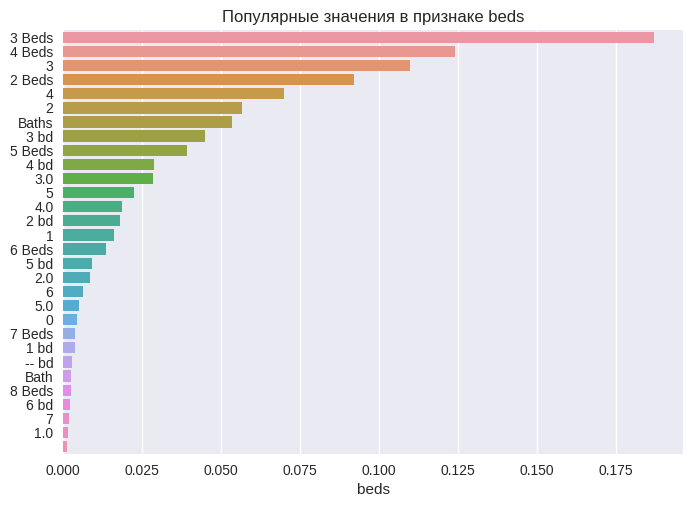

In [ ]:
# посмотрим на топ популярных признаков
top_values = train_data['beds'].value_counts(normalize=True)[:30]
fig = plt.figure()
barplot = sns.barplot(x=top_values, y=top_values.index)
barplot.set_title('Популярные значения в признаке beds');

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
create_categorical_feats(
    data=train_data.copy(),
    col_name='beds',
    iter_set=top_values.index,
    info_level=0.03
)

Потенциальные признаки: ['3 Beds', '4 Beds', '3', '2 Beds', '4', '2', 'Baths', '3 bd']


Извлечём из колонки 'beds' числа и создадим числовой признак. Пропуски заполним медианным значением на тренировочной выборке - 3.

Дополнительно создадим колонку:
- en_suite_bath (спальня с личным санузлом).

### Анализ признака 'state'

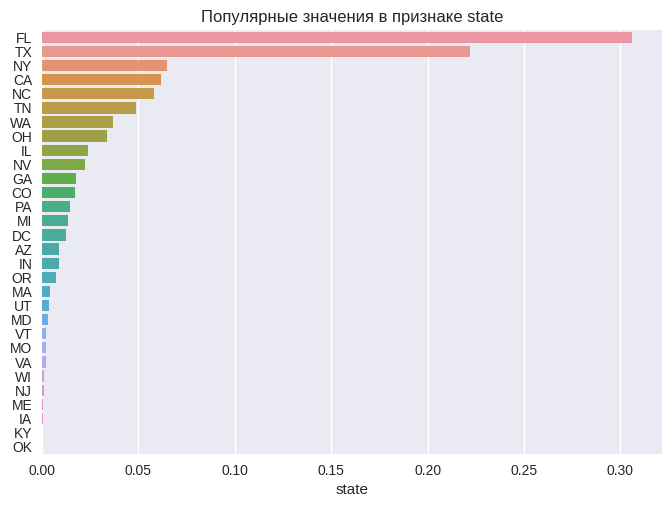

In [ ]:
# посмотрим на топ популярных признаков
top_values = train_data['state'].value_counts(normalize=True)[:30]
fig = plt.figure()
barplot = sns.barplot(x=top_values, y=top_values.index)
barplot.set_title('Популярные значения в признаке state');

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
create_categorical_feats(
    data=train_data.copy(),
    col_name='state',
    iter_set=top_values.index,
    info_level=0.03
)

Потенциальные признаки: ['FL', 'TX', 'NY', 'CA', 'NC', 'TN', 'WA', 'OH']


### Анализ признака 'stories'

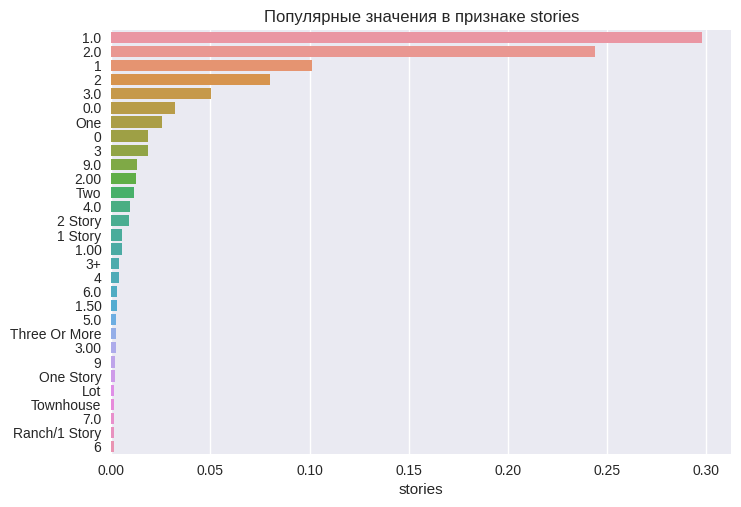

In [ ]:
# посмотрим на топ популярных признаков
top_values = train_data['stories'].value_counts(normalize=True)[:30]
fig = plt.figure()
barplot = sns.barplot(x=top_values, y=top_values.index)
barplot.set_title('Популярные значения в признаке stories');

In [ ]:
# посмотрим из каких значений можно сделать колонки-индикаторы
create_categorical_feats(
    data=train_data.copy(),
    col_name='stories',
    iter_set=top_values.index,
    info_level=0.03
)

Потенциальные признаки: ['1.0', '1', '3.0']


In [ ]:
# количество пропусков
train_data['stories'].isna().mean()

0.4000226845874908

В признаке 'stories' пропуски заполним 0. Из остальных значений извлечём числа. Значения не содержащие чисел заполним 1.

### Анализ признаков 'mls-id' и 'MlsId'

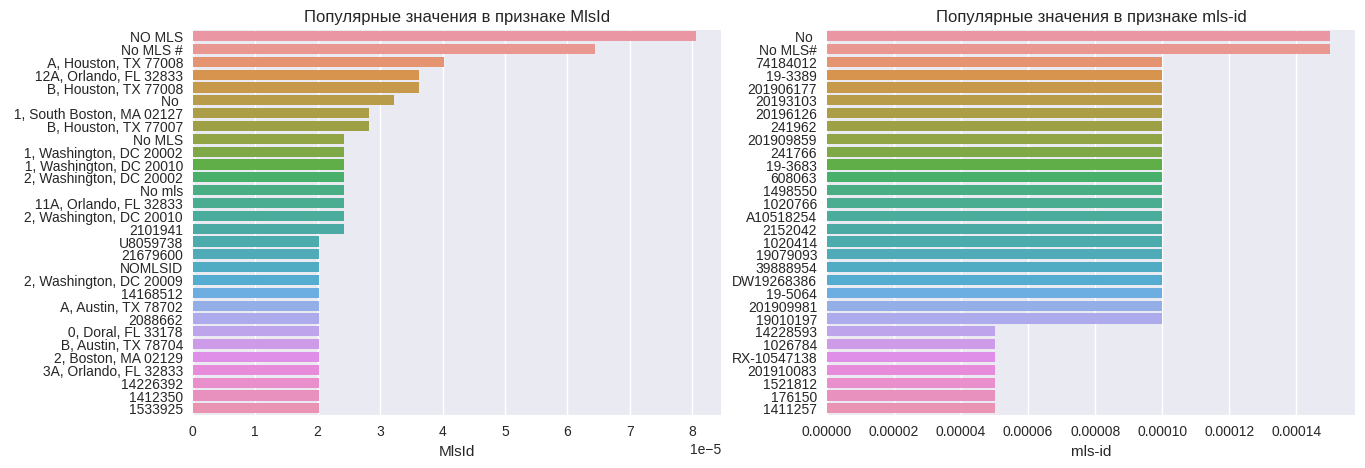

In [ ]:
# посмотрим на топ популярных признаков
top_mls_id = train_data['mls-id'].value_counts(normalize=True)[:30]
top_mlsid = train_data['MlsId'].value_counts(normalize=True)[:30]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=top_mlsid, y=top_mlsid.index, ax=ax[0])
sns.barplot(x=top_mls_id, y=top_mls_id.index, ax=ax[1])
ax[0].set_title('Популярные значения в признаке MlsId');
ax[1].set_title('Популярные значения в признаке mls-id');

Из признаков 'mls-id' и 'MlsId' создадим колонку-индикатор означающее есть ли идентификатор MLS
(Multiple Listing Service - Служба множественного листинга).

### Анализ признаков 'private pool' и 'PrivatePool'

In [ ]:
# посмотрим на значения в признаках
print(train_data['private pool'].value_counts())
print(train_data['PrivatePool'].value_counts())

Yes    3359
Name: private pool, dtype: int64
yes    22919
Yes     9244
Name: PrivatePool, dtype: int64


Создадим колонку-индикатор наличия бассейна.

# Проеобразование признаков

Создадим функцию которая на основании проведённого анализа подготовит даные для дальнейшей работы.

In [55]:
%%time

# объявляем функцию
def create_expert_feats(data):
    """
    Функция создающая необходимые для
    обучения и предсказания признаки в датасете.
    Args:
        data: набор данных
    Returns:
        data: обработанный набор данных
    """

    # создаём колонки-индикаторы из признака 'status'
    data['for_sale'] = (
        data['status']
        .apply(lambda x: 1 if 'forsale' in re.sub(
            '[^a-z]','',str(x).lower()
        ) else 0)
        .astype('int8')
    )

    # создаём колонки-индикаторы из признака 'propertyType'
    property_types = ['single_family', 'condo', 'land', 'townhouse']
    for prop in property_types:
        prop_regex = re.sub('[^a-z]', '', str(prop).lower())
        data[prop] = (
            data['propertyType']
            .apply(lambda x: 1 if prop_regex in re.sub(
                '[^a-z]', '', str(x).lower()
            ) else 0)
            .astype('int8')
        )

    # создаём колонки-индикаторы из признака 'street'
    str_types = ['St', 'Dr', 'Ln', 'W', 'Ct', 'SW', 'E', 'NW', 'Blvd']
    for str_type in str_types:
        data[str_type.lower()] = data['street'].apply(
            lambda x: 1 if str_type in str(x).split(' ') else 0
        ).astype('int8')

    # преобразуем признак 'baths' к числовому типу
    def get_baths(x):
        x_list = str(x).split(' ')
        if x_list[0] == 'Bathrooms:':
            x = x_list[-1]
        else:
            x = x_list[0]
        try:
            return float(
                str(x)
                .split('-')[0]
                .replace(',', '.')
                .replace('+', '')
            )
        except:
            return np.NaN
    data['baths'] = (
        data['baths']
        .apply(get_baths)
        .astype('float')
        .fillna(2.5)
    )

    # обрабатываем признаки годов постройки и реновации
    data['year_built'] = (
        data['Year built']
        .fillna(data['Remodeled year'])
        .fillna(1985)
        .astype('int')
    )

    # создаём колонку-индикатор было ли здание реконструировано
    data['remodeled'] = (
        data['Remodeled year']
        .apply(lambda x: 0 if (x is np.NaN or x is None) else 1)
        .astype('int8')
    )

    # создаём колонки-индикаторы из признака 'Heating'
    data['forced_air'] = (
        data['Heating']
        .apply(lambda x: 1 if 'forcedair' in re.sub(
            '[^a-z]','',str(x).lower()
        ) else 0)
        .astype('int8')
    )
    data['other_heating'] = (
        data['Heating']
        .apply(lambda x: 0 if (x is np.NaN or x is None) else 1)
        .astype('int8')
    ) - data['forced_air']

    # создаём колонки-индикаторы из признака 'Cooling'
    data['central_cooling'] = (
        data['Cooling']
        .apply(lambda x: 1 if 'central' in re.sub(
            '[^a-z]','',str(x).lower()
        ) else 0)
        .astype('int8')
    )

    # преобразуем признак 'Parking' к числовому типу
    def get_parking(x):
        numbers = re.findall('[0-9]+', str(x))
        if len(numbers) == 0:
            return 1
        if len(numbers) == 1:
            return numbers[0]
        else:
            counter = 0
            for num in numbers:
                counter += int(num)
            return counter
    data['parking'] = data['Parking'].fillna(0).apply(get_parking).astype('int')

    # создаём дополнительные колонки-индикаторы из признака 'Parking'
    data['attached_garage'] = (
        data['Parking']
        .apply(lambda x: 1 if 'attachedgarage' in re.sub(
            '[^a-z]','',str(x).lower()
        ) else 0)
        .astype('int8')
    )
    data['detached_garage'] = (
        data['Parking']
        .apply(lambda x: 1 if 'detachedgarage' in re.sub(
            '[^a-z]','',str(x).lower()
        ) else 0)
        .astype('int8')
    )

    # преобразуем признак 'lotsize' к числовому типу
    def get_lotsize(x):
        if (x is np.NaN) or (x is None):
            return 0.19
        x_list = str(x).split(' ')
        if len(x_list) == 1:
            return float(x_list[0].replace(',', '')) / 43560
        if x_list[1].lower()[:4] == 'acre':
            return float(x_list[0].replace(',', ''))
        if x_list[1].lower()[:2] == 'sq':
            return float(x_list[0].replace(',', '')) / 43560
    data['lotsize'] = (
        data['lotsize']
        .apply(get_lotsize)
        .abs()
    )

    # преобразуем признак 'fireplace' к числовому типу
    def get_fireplace(x):
        x_list = str(x).split()
        try:
            return int(x_list[0])
        except:
            return 1
    data['fireplace'] = (
        data['fireplace']
        .fillna(0)
        .apply(get_fireplace)
        .astype('int')
    )


    # создаём колонки-индикаторы из признака 'city'
    data['houston'] = (
        data['city']
        .apply(lambda x: 1 if 'houston' in re.sub(
            '[^a-z]','',str(x).lower()
        ) else 0)
        .astype('int8')
    )
    data['san_antonio'] = (
        data['city']
        .apply(lambda x: 1 if 'sanantonio' in re.sub(
            '[^a-z]','',str(x).lower()
        ) else 0)
        .astype('int8')
    )
    data['miami'] = (
        data['city']
        .apply(lambda x: 1 if 'miami' in re.sub(
            '[^a-z]','',str(x).lower()
        ) else 0)
        .astype('int8')
    )

    # создаём колонку среднего рейтинга школ
    def get_avg_schools_rating(x):
        if len(x) == 0:
            return np.NaN
        score_sum = 0
        score_count = 0
        for score in x:
            score = score.split('/')[0]
            if score.isdigit():
                score_sum += int(score)
                score_count += 1
        if score_count == 0:
            return np.NaN
        else: return score_sum / score_count
    data['schools_rating'] = (
        data['schools_rating']
        .apply(get_avg_schools_rating)
        .fillna(5)
    )

    # создаём колонку среднего расстояния до школы
    def get_avg_schools_distance(x):
        if len(x) == 0:
            return np.NaN
        distance_sum = 0
        distance_count = 0
        for distance in x:
            distance = distance[:-2] # убераем окончание mi
            distance_sum += float(distance)
            distance_count += 1
        if distance_count == 0:
            return np.NaN
        else: return distance_sum / distance_count
    data['schools_distance'] = (
        data['schools_distance']
        .apply(get_avg_schools_distance)
        .fillna(1.78)
    )

    # создаём колонки-индикаторы из признака 'schools_grades'
    def get_pk_5(x):
        for grade in x:
            if ('P' in str(grade) or 'K' in str(grade)) and '5' in str(grade):
                return 1
        return 0
    def get_pk_6(x):
        for grade in x:
            if ('P' in str(grade) or 'K' in str(grade)) and '6' in str(grade):
                return 1
        return 0
    def get_pk_8(x):
        for grade in x:
            if ('P' in str(grade) or 'K' in str(grade)) and '8' in str(grade):
                return 1
        return 0
    def get_pk_12(x):
        for grade in x:
            if ('P' in str(grade) or 'K' in str(grade)) and '12' in str(grade):
                return 1
        return 0
    def get_6_8(x):
        for grade in x:
            if '6' in str(grade) and '8' in str(grade):
                return 1
        return 0
    def get_7_8(x):
        for grade in x:
            if '7' in str(grade) and '8' in str(grade):
                return 1
        return 0
    def get_9_12(x):
        for grade in x:
            if '9' in str(grade) and '12' in str(grade):
                return 1
        return 0
    data['pk_5'] = data['schools_grades'].apply(get_pk_5).astype('int8')
    data['pk_6'] = data['schools_grades'].apply(get_pk_6).astype('int8')
    data['pk_8'] = data['schools_grades'].apply(get_pk_8).astype('int8')
    data['pk_12'] = data['schools_grades'].apply(get_pk_12).astype('int8')
    data['6_8'] = data['schools_grades'].apply(get_6_8).astype('int8')
    data['7_8'] = data['schools_grades'].apply(get_7_8).astype('int8')
    data['9_12'] = data['schools_grades'].apply(get_9_12).astype('int8')

    # создаём колонки-индикатры из признака 'schools_name'
    data['abes'] = (
        data['schools_name']
        .apply(lambda x: 1 if 'Air Base Elementary School' in x else 0)
        .astype('int8')
    )
    data['rmvti'] = (
        data['schools_name']
        .apply(lambda x: 1 if 'Robert Morgan Voc-Tech Institute' in x else 0)
        .astype('int8')
    )

    # преобразуем признак 'sqft' к числовому типу
    def get_sqft(x):
        if (x is np.NaN) or (x is None):
            return np.NaN
        x_list = str(x).split(' ')
        if x_list[-1] == 'sqft':
            try:
                # если встречается диапазон, берём только первую часть
                return float(x_list[-2].split('-')[0].replace(',', ''))
            except:
                return np.NaN
        else:
            try:
                return float(x_list[-1].split('-')[0].replace(',', ''))
            except:
                return np.NaN
    data['sqft'] = (
        data['sqft']
        .apply(get_sqft)
        .fillna(1800)
        .astype('int')
    )


    # создаём колонки-индикаторы из признака 'zipcode'
    data['zipcode'] = data['zipcode'].apply(lambda x: x[0])
    zip_codes = ['3', '7', '9', '1', '2', '4', '8']
    for zip in zip_codes:
        data['zip_'+zip] = (
            data['zipcode']
            .apply(lambda x: 1 if x == zip else 0)
            .astype('int8')
        )

    # преобразуем признак 'beds' к числовому типу
    def get_beds(x):
        x_list = str(x).split(' ')
        false_info = ['acre', 'bath', 'sqft']
        if x_list[-1].lower()[:4] in false_info:
            return np.NaN
        try:
            return float(x_list[0].split('-')[0])
        except:
            return np.NaN
    data['en_suite_bath'] = (
        data['beds']
        .apply(lambda x: 1 if 'bath' in re.sub(
            '[^a-z]','',str(x).lower()
        ) else 0)
        .astype('int8')
    )
    data['beds'] = (
        data['beds']
        .apply(get_beds)
        .fillna(3)
        .astype('int')
    )

    # создаём колонки-индикаторы из признака 'state'
    states = ['FL', 'TX', 'NY', 'CA', 'NC', 'TN', 'WA', 'OH']
    for state in states:
        data[state.lower()] = (
            data['state']
            .apply(lambda x: 1 if x == state else 0)
            .astype('int8')
        )

    # преобразуем признак 'stories' к числовому типу
    def get_stories(x):
        x = str(x).split(' ')[0].split('/')[-1]
        if 'one' in x.lower():
            return 1
        if 'two' in x.lower():
            return 2
        if 'three' in x.lower():
            return 3
        try:
            return float(x.replace('+', '').replace(',', '').split('-')[0])
        except:
            return 1
    data['stories'] = (
        data['stories']
        .fillna(0)
        .apply(get_stories)
    )

    # создаём колонку-индикатор есть ли идентификатор MLS
    data['mls_id'] = (
        data['MlsId']
        .fillna(data['mls-id'])
        .apply(lambda x: 0 if (
            (x is np.NaN) or (x is None) or ('no' in str(x).lower())
        ) else 1)
        .astype('int8')
    )

    # создаём колонку-индикаторы есть ли бассейн'
    data['private_pool'] = (
        data['PrivatePool']
        .fillna(data['private pool'])
        .apply(lambda x: 0 if (x is np.NaN or x is None) else 1)
        .astype('int8')
    )

    # убираем признаки с dtypes "object"
    object_columns = [s for s in data.columns if data[s].dtypes == 'object']
    data.drop(object_columns, axis = 1, inplace = True)

    return data


# преобразовываем данные
train_remastered = create_expert_feats(train_data.copy())
test_remastered = create_expert_feats(test_data.copy())

CPU times: user 27 s, sys: 388 ms, total: 27.4 s
Wall time: 27.4 s


# Визуализация данных

Посмотрим на зависимость стоимости недвижимости от рейтинга школ.

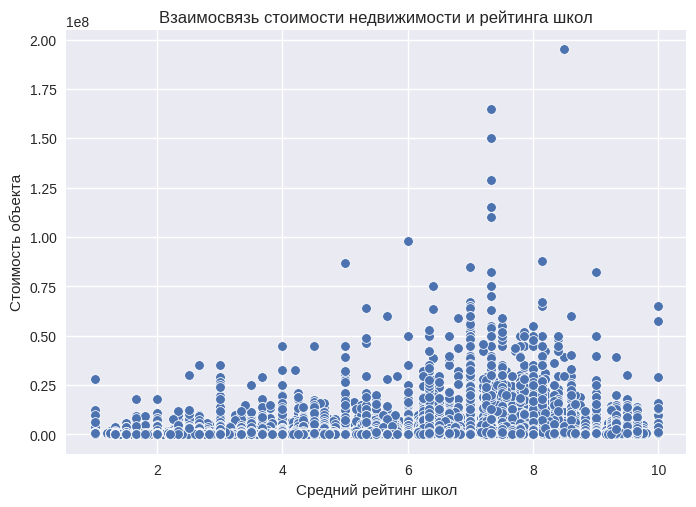

In [ ]:
fig = plt.figure()
scatterplot = sns.scatterplot(
    data=train_remastered,
    x='schools_rating',
    y='target'
)
scatterplot.set_title('Взаимосвязь стоимости недвижимости и рейтинга школ')
scatterplot.set_xlabel('Средний рейтинг школ')
scatterplot.set_ylabel('Стоимость объекта');

Прослеживается некоторая тенденция роста оценки школы с ростом стоимости недвижимости. Вблизи объектов с низкой стоимостью встречаются школы с любым рейтингом, однако на элитных объектах стоимостью от 50 млн нет школ с рейтингом ниже 5.

# Очистка данных

### Мультиколлинеарность

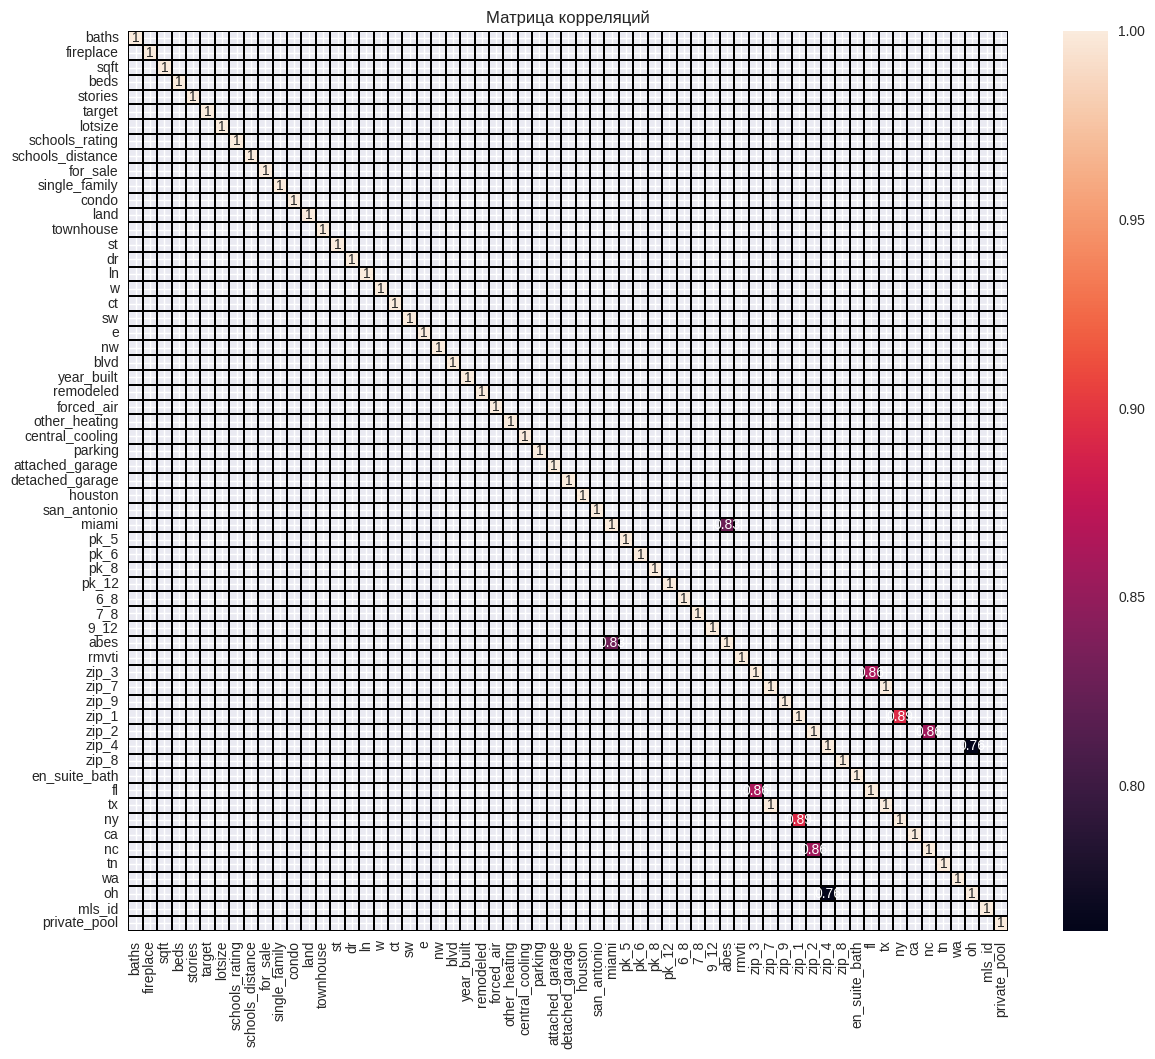

In [ ]:
# оценим данные на наличие мультиколлинеарности
corr = train_remastered.corr(method = 'spearman')

# выведем только данные с высоким уровнем корреляции
mask_1 = abs(corr) <= -0.75
mask_2 = abs(corr) >= 0.75
corr = corr[mask_1 | mask_2]

# строим корреляционную матрицу
fig = plt.figure(figsize=(11, 9))
ax = fig.add_axes([0, 0, 1, 1])
heatmap = sns.heatmap(
    data = corr,
    linewidth = 0.3,
    linecolor = 'black',
    annot=True
)
heatmap.set_title('Матрица корреляций');

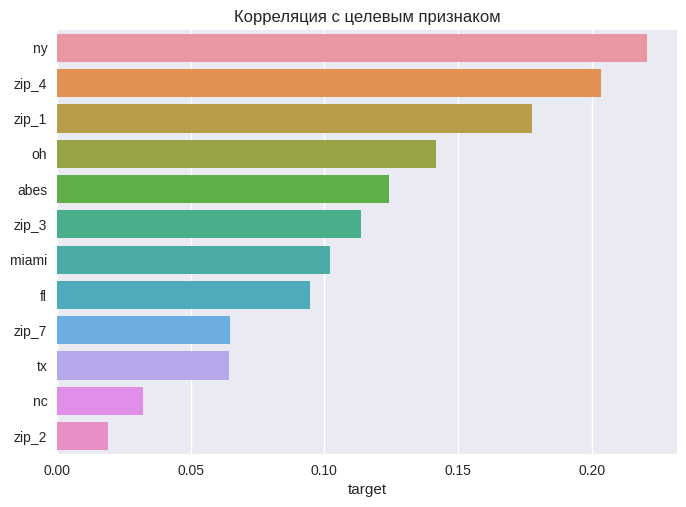

In [ ]:
# посмотрим как скоррелированные признаки коррелируют с целевым признаком
target_corr = train_remastered.corr(method = 'spearman')['target'].loc[
    ['miami', 'abes', 'zip_3', 'zip_7', 'zip_1', 'zip_2', 'zip_4', 'fl', 'tx',
     'ny', 'nc', 'oh']
].abs().sort_values(ascending=False)
fig = plt.figure()
barplot = sns.barplot(x=target_corr, y=target_corr.index)
barplot.set_title('Корреляция с целевым признаком');

In [ ]:
# удаляем сильно скоррелировнные признаки
# оставляем те, которые лучше коррелируют с целевыми признаком
train_remastered = train_remastered.drop(
    ['zip_1', 'oh', 'miami', 'fl', 'tx', 'zip_2'],
    axis=1
)
test_remastered = test_remastered.drop(
    ['zip_1', 'oh', 'miami', 'fl', 'tx', 'zip_2'],
    axis=1
)

### Выбросы

In [ ]:
# посмотрим на описательные статистики числовых признаков
num_columns = ['baths', 'year_built', 'parking', 'lotsize', 'fireplace',
               'schools_rating', 'schools_distance', 'sqft', 'beds', 'stories',
               'target']
train_remastered[num_columns].describe()

,baths,year_built,parking,lotsize,fireplace,schools_rating,schools_distance,sqft,beds,stories,target
count,299763.000000,2.997630e+05,299763.000000,299763.000000,299763.000000,299763.000000,299763.000000,2.997630e+05,299763.000000,299763.000000,2.997630e+05
mean,3.095471,3.738202e+06,1.399102,2.256310,0.285389,5.164473,2.840813,6.937973e+03,3.255819,1.143507,6.477720e+05
std,18.098635,1.446459e+09,26.244009,172.840645,0.494073,1.920435,4.849177,1.676194e+06,1.423964,3.628392,1.873422e+06
min,0.000000,0.000000e+00,0.000000,0.000005,0.000000,1.000000,0.020000,0.000000e+00,0.000000,0.000000,1.000000e+00
25%,2.000000,1.962000e+03,0.000000,0.144031,0.000000,3.666667,1.066667,1.306000e+03,3.000000,0.000000,1.860000e+05
50%,2.500000,1.985000e+03,0.000000,0.190000,0.000000,5.000000,1.780000,1.800000e+03,3.000000,1.000000,3.200000e+05
75%,3.000000,2.005000e+03,1.000000,0.250000,1.000000,6.500000,3.250000,2.455000e+03,4.000000,2.000000,5.829900e+05
max,750.000000,5.599906e+11,5209.000000,49299.440000,12.000000,10.000000,1187.510000,7.959794e+08,144.000000,1120.000000,1.950000e+08


Удалим из тренировочной выборки строки со слишком низкими или высокими значениями в числовых признаках.

Примечание. Выбросы выявлялись методом "жадного" перебора - из тренировочной выборки удалялись крайние значения числовых признаков и рассчитывалась RMSLE на тестовой выборке. В целях экономии времени в качестве тестируемой модели использовалась линейная регрессия.

In [ ]:
mask_1 = train_remastered['year_built'] < 5.599906e+11
mask_2 = train_remastered['lotsize'] < 49299.44
mask_3 = train_remastered['fireplace'] < 12
mask_4 = train_remastered['schools_rating'] > 1.2
mask_5 = train_remastered['sqft'] < 4.566024e+08
mask_6 = train_remastered['beds'] > 0
mask_7 = train_remastered['beds'] < 78
mask_8 = train_remastered['stories'] < 96
mask_9 = train_remastered['target'] > 1
train_remastered = train_remastered[
    mask_1 & mask_2 & mask_3 & mask_4 & mask_5
    & mask_6 & mask_7 & mask_8 & mask_9
]
print(
    'Число найденных выбросов:',
    train_data.shape[0] - train_remastered.shape[0]
)

Число найденных выбросов: 2924


### Дубликаты

In [ ]:
# проверяем дубликаты в тренировочной выборке
mask = train_remastered.duplicated()
duplicates = train_remastered[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

Число найденных дубликатов: 1752


In [ ]:
# удаляем дубликаты
train_remastered = train_remastered.drop_duplicates()

# Разработка и оценка качества моделей

In [ ]:
# разделяем данные на признаки и ответы
X_train = train_remastered.drop('target', axis=1)
X_test = test_remastered.drop('target', axis=1)
y_train = train_remastered['target']
y_test = test_remastered['target']

### Маштабирование

Нормализуем тренировочную и тестовую выборки с помощью min-max-нормализации (MinMaxScaler). Min-max-нормализация не искажает изначальный вид бинарных категориальных признаков, в отличие от стандартизации.

In [ ]:
# составляем список факторов
features = X_train.columns

# инициализируем стандартизатор MinMaxScaler
scaler = MinMaxScaler()

# производим стандартизацию
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# составляем DataFrame из результатов
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features)
X_train_scaled.head()

,baths,fireplace,sqft,beds,stories,lotsize,schools_rating,schools_distance,for_sale,single_family,...,zip_4,zip_8,en_suite_bath,ny,ca,nc,tn,wa,mls_id,private_pool
0,0.004000,0.000000,0.000002,0.020833,0.000893,4.656506e-06,0.555556,0.003725,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.004000,0.083333,0.000005,0.020833,0.003571,7.603178e-07,0.500000,0.000669,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002667,0.000000,0.000002,0.013889,0.000893,3.853892e-06,0.755556,0.000815,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.002667,0.083333,0.000001,0.013889,0.001786,6.546127e-07,0.166667,0.000783,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.002667,0.083333,0.000002,0.020833,0.000000,3.245086e-06,0.296296,0.002145,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Метрики

Логорифмическое распределение целевого признака отлично от нормального, однако  имеет меньший хвост чем нелогорифмическое распределение. Для построения моделей будем использовать логорифм целевого признака, а оценивать модель по среднеквадратичной ошибке между логарифмом прогнозируемого значения и логарифмом наблюдаемой цены продажи (RMSLE). Таким образом ошибки в прогнозировании дорогих и дешевых домов одинаково повлияют на результат.

In [3]:
# создадим функцию для оценки метрик
def print_metrics(y_true, y_pred):
    """
    Функция выводит:
    - RMSLE (техническая метрика для оценки модели),
    - MAE (бизнес-метрика для интерпритации полученного результата).
    """
    print(
        'Test RMSLE:',
        np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred)))
    )
    print('Test MAE:', round(mean_absolute_error(y_test, y_pred)))
    print()

### Baseline модели

In [ ]:
# создаём базовую модель со средним значением
print('Baseline model with mean value:\n')
y_pred_mean = pd.Series(y_train.mean(), index=y_test.index)
print_metrics(y_test, y_pred_mean)

Baseline model with mean value:

Test RMSLE: 1.4111838680382431
Test MAE: 570251



In [ ]:
# создаём базовую модель с медианным значением
print('Baseline model with median value:\n')
y_pred_median = pd.Series(y_train.median(), index=y_test.index)
print_metrics(y_test, y_pred_median)

Baseline model with median value:

Test RMSLE: 1.2007506351359352
Test MAE: 456197



In [ ]:
# создаём базовую модель с модальным значением
print('Baseline model with mode value:\n')
y_pred_mode = pd.Series(y_train.mode()[0], index=y_test.index)
print_metrics(y_test, y_pred_mode)

Baseline model with mode value:

Test RMSLE: 1.2416460276922936
Test MAE: 472699



### Линейная регрессия

Обучим модель SGDRegressor (численное решение через стохастический градиентный спуск).

In [ ]:
%%time

# cоздаём объект класса линейной регрессии с SGD
sgd_lr = SGDRegressor(
    random_state=42,
    tol=0.1 # критерий остановки
)

# обучаем модель — ищем параметры по методу SGD
# подаём стандартизованные данные
sgd_lr.fit(X_train_scaled, np.log(y_train))
y_pred_sgd = np.exp(sgd_lr.predict(X_test_scaled))

# выводим метрики
print_metrics(y_test, y_pred_sgd)

Test RMSLE: 0.9436125868226529
Test MAE: 402203

CPU times: user 1.31 s, sys: 38.6 ms, total: 1.35 s
Wall time: 1.39 s


Отлично, мы превзошли baseline :)

Попробуем улучшить результат, обучив модель LinearRegression (аналитическое решение через метод наименьших квадратов).

In [ ]:
%%time

# создаём объект класса LinearRegression
lr_model = LinearRegression()

# обучаем модель — ищем параметры по МНК
lr_model.fit(X_train_scaled, np.log(y_train))

# делаем предсказания
y_pred_lr = np.exp(lr_model.predict(X_test_scaled))

# выводим метрики
print_metrics(y_test, y_pred_lr)

Test RMSLE: 0.9284117857146046
Test MAE: 846842

CPU times: user 2.1 s, sys: 512 ms, total: 2.61 s
Wall time: 2.13 s


Аналитическое решение линейной регрессии дало лучший результат по метрике RMSLE по сравнению с численным решением, но по метрике MAE (средняя абсолютная ошибка) оно хуже даже чем baseline.

Посмотрим как распределяются ошибки аналитического решения.

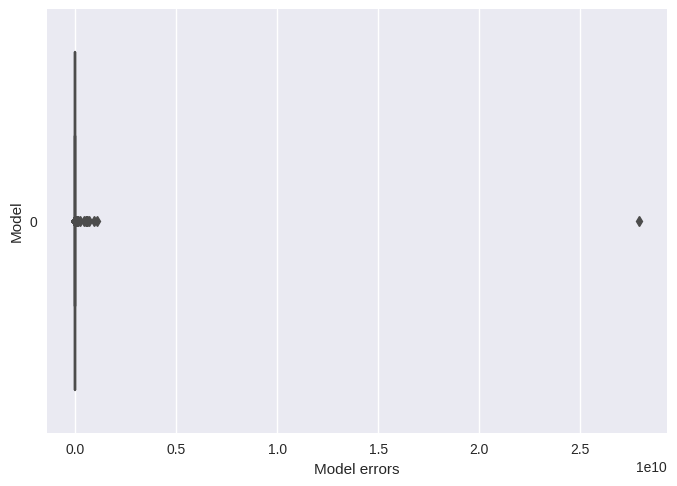

In [ ]:
# визуализируем ошибки
fig, ax = plt.subplots() # фигура + координатная плоскость
y_test_errors = abs(y_test - y_pred_lr)

# для удобства визуализации составим Series из ошибок
pred_series = pd.Series({'Test errors': y_test_errors})

# cтроим коробчатую диаграмму для ошибок
sns.boxplot(data=pred_series, orient='h', ax=ax)
ax.set_xlabel('Model errors') # название оси абсцисс
ax.set_ylabel('Model');       # название оси ординат

Мы получили лучше результат по метрике RMSLE - это говорит о том, что аналитическое решение линейной регрессии имеет лучшую обобщающую способность по сравнению с численным решением, но как мы видим на диаграмме, на 1 объекте модель ошибается свыше чем на  25 млрд, что сильно изкажает метрику МАЕ.

In [ ]:
%%time

# построим линейную регрессию с L2-регуляризацией
ridge_lr = Ridge()
ridge_lr.fit(X_train_scaled, np.log(y_train))
y_pred_ridge = np.exp(ridge_lr.predict(X_test_scaled))
print_metrics(y_test, y_pred_ridge)

Test RMSLE: 0.9279732190094566
Test MAE: 795077

CPU times: user 238 ms, sys: 275 ms, total: 513 ms
Wall time: 228 ms


Линейная регрессия с регуляризацией ещё немного улучшила результат. Построим столбчатую диаграмму коэффициентов каждого из факторов.

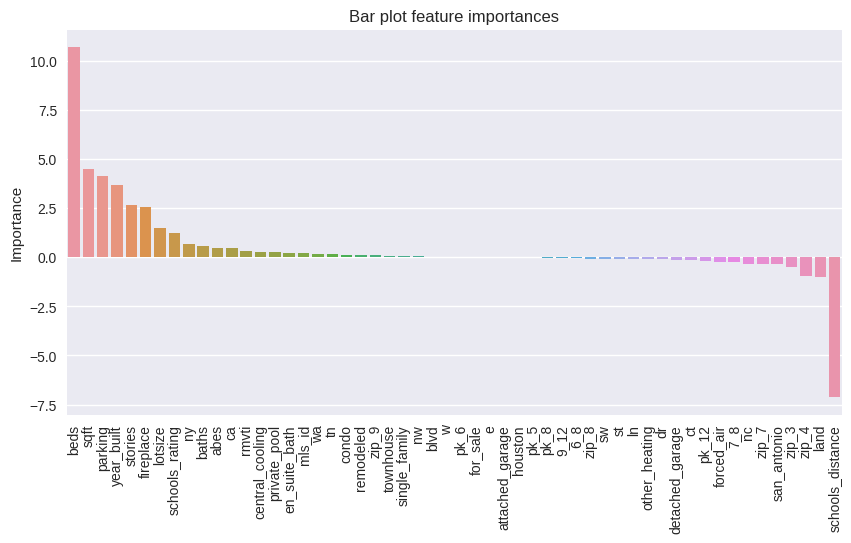

In [ ]:
feat_importances = pd.Series(
    ridge_lr.coef_ ,             # коэффициенты
    index=X_train_scaled.columns # признаки
).sort_values(ascending=False)

# строим столбчатую диаграмму
fig, ax = plt.subplots(figsize=(10, 5)) # фигура + координатная плоскость
sns.barplot(x = feat_importances.index, y = feat_importances, ax = ax)
ax.set_title('Bar plot feature importances') # название графика
ax.set_ylabel('Importance')                  # название оси ординат
ax.xaxis.set_tick_params(rotation = 90)      # поворот меток на оси абсцисс

По версии линейной регрессии с регуляризацией, наиболее значимые признаки для предсказания стоимости недвижимости - количество спален, расстояние до школ и площадь.

### Дерево решений

In [ ]:
%%time

# создаём объект класса DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)

# обучаем модель по алгоритму CART
dt_reg.fit(X_train_scaled, np.log(y_train))
print('Глубина дерева:', dt_reg.get_depth())

# делаем предсказания
y_pred_dt = np.exp(dt_reg.predict(X_test_scaled))

# выводим метрики
print_metrics(y_test, y_pred_dt)

Глубина дерева: 56
Test RMSLE: 0.7368862097341178
Test MAE: 286868

CPU times: user 7.9 s, sys: 36.9 ms, total: 7.94 s
Wall time: 7.99 s


Для лучшей оценки обобщающей способности воспользуемся кросс-валидацией и настройкой гиперпараметров с помощью класса GridSearchCV библиотеки sklearn.

In [ ]:
%%time

# сетка гиперпараметров
param_grid = {
    'max_depth': [10, 20, 30, 40, 50],      # максимальная глубина дерева
    'min_samples_leaf': [5, 10, 15, 20, 25] # минимальное число объектов в листе
}

# создаём и обучаем объект класса GridSearchCV
dt_reg = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5 # количество фолдов кросс-валидации
)
dt_reg.fit(X_train_scaled, np.log(y_train))
print("Наилучшие значения параметров: {}".format(dt_reg.best_params_))

Наилучшие значения параметров: {'max_depth': 40, 'min_samples_leaf': 15}
CPU times: user 8min 19s, sys: 4.77 s, total: 8min 24s
Wall time: 9min 4s


In [ ]:
# делаем предсказания
y_pred_dt = np.exp(dt_reg.predict(X_test_scaled))

# выводим метрики
print_metrics(y_test, y_pred_dt)

Test RMSLE: 0.6273285962477148
Test MAE: 266008



Дерево решений уловило нелинейные закономерности и значительно улучшило метрики. Попробуем повысить качество предсказаний с помощью ансамблей над решающими деревьями.

### Бэггинг. Случайный лес

Для поиска гиперпараметров случайного леса воспользуемся библиотекой Hyperopt. Параметр max_features выставим в значение 'sqrt', чтобы строить деревья на выборочных колонках.

In [ ]:
%%time

def hyperopt_rf(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_samples': params['max_samples']
    }
    model = RandomForestRegressor(
        **params,
        max_features='sqrt',
        random_state=42
    )
    # обучаем модель и рассчитываем RMSLE на кросс-валидации
    score = cross_val_score(
        model,
        X_train_scaled,
        np.log(y_train),
        scoring='neg_root_mean_squared_error',
        cv=5
    ).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


# зададим пространство поиска гиперпараметров
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 400, 1),
    'max_depth': hp.quniform('max_depth', 6, 56, 1),
    'max_samples': hp.quniform('max_samples', 0.01, 1, 0.01)
}

# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов
best = fmin(
    hyperopt_rf,      # наша функция
    space=space,      # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации (установлен по умолчанию)
    max_evals=20,     # максимальное количество итераций
    trials=trials,    # логирование результатов
    rstate=np.random.default_rng(42) # фиксируем для повторяемости результата
)
print('Наилучшие значения гиперпараметров: {}'.format(best))

100%|██████████| 20/20 [2:23:34<00:00, 430.73s/trial, best loss: 0.5152601585594276]
Наилучшие значения гиперпараметров: {'max_depth': 47.0, 'max_samples': 0.8200000000000001, 'n_estimators': 365.0}
CPU times: user 2h 21min 50s, sys: 1min 14s, total: 2h 23min 5s
Wall time: 2h 23min 34s


In [ ]:
%%time

# создаём объект класса RandomForestRegressor c лучшими гиперпараметрами
rf_reg = RandomForestRegressor(
    n_estimators=365,
    max_depth=47,
    max_samples=0.82,
    max_features='sqrt',
    random_state=42
)

# обучаем модель
rf_reg.fit(X_train_scaled, np.log(y_train))

# делаем предсказания
y_pred_rf = np.exp(rf_reg.predict(X_test_scaled))

# выводим метрики
print_metrics(y_test, y_pred_rf)

Test RMSLE: 0.5133327208887578
Test MAE: 216399

CPU times: user 4min 51s, sys: 5.34 s, total: 4min 57s
Wall time: 4min 55s


Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.

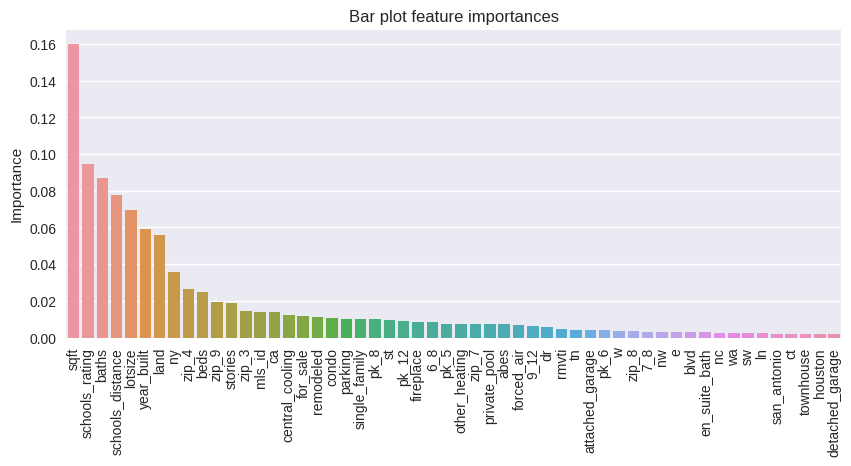

In [ ]:
feat_importances = pd.Series(
    rf_reg.feature_importances_, # важность признаков
    index=X_train_scaled.columns # признаки
).sort_values(ascending=False)

# строим столбчатую диаграмму
fig, ax = plt.subplots(figsize=(10, 4)) # фигура + координатная плоскость
sns.barplot(x = feat_importances.index, y = feat_importances, ax = ax)
ax.set_title('Bar plot feature importances') # название графика
ax.set_ylabel('Importance')                  # название оси ординат
ax.xaxis.set_tick_params(rotation = 90)      # поворот меток на оси абсцисс

По версии случайного леса, наиболее значимые признаки для предсказания стоимости недвижимости - площадь, рейтинг школ и количество ванных комнат.

### Градиентный бустинг

Для поиска гиперпараметров градиентного бустинга воспользуемся библиотекой optuna. Параметр max_features выставим в значение 'sqrt', чтобы строить деревья на выборочных колонках.

In [ ]:
%%time

def optuna_gb(trial):
    # задаём пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 400, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1, step=0.01)
    max_depth = trial.suggest_int('max_depth', 1, 5, 1)
    subsample = trial.suggest_float('subsample', 0.01, 1, step=0.01)

    # создаём модель
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        max_features='sqrt',
        subsample=subsample,
        random_state=42
    )
    # обучаем модель и рассчитываем RMSLE на кросс-валидации
    score = cross_val_score(
        model,
        X_train_scaled,
        np.log(y_train),
        scoring='neg_root_mean_squared_error',
        cv=5
    ).mean()
    return score


# создаём объект исследования
study = optuna.create_study(
    study_name='GradientBoostingRegressor',
    direction='maximize'
)
# ищем лучшую комбинацию гиперпараметров n_trials раз
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(optuna_gb, n_trials=20)
print('Наилучшие значения гиперпараметров: {}'.format(study.best_params))

[I 2023-10-17 11:45:58,684] A new study created in memory with name: GradientBoostingRegressor


Наилучшие значения гиперпараметров: {'n_estimators': 304, 'learning_rate': 0.5800000000000001, 'max_depth': 5, 'subsample': 0.79}
CPU times: user 49min 54s, sys: 7.64 s, total: 50min 2s
Wall time: 50min 27s


In [ ]:
# создаём объект класса GradientBoostingRegressor c лучшими гиперпараметрами
gb_reg = GradientBoostingRegressor(
    **study.best_params,
    max_features='sqrt',
    random_state = 42
)

# обучаем модель
gb_reg.fit(X_train_scaled, np.log(y_train))

# делаем предсказания
y_pred_gb = np.exp(gb_reg.predict(X_test_scaled))

# выводим метрики
print_metrics(y_test, y_pred_gb)

Test RMSLE: 0.6080169664668165
Test MAE: 262122



##### Тут я несколько раз переопределял пространство гиперпараметров и искал наилучшие комбинации, но мне так и не удалось превзойти модель случайного леса.

In [ ]:
%%time

def optuna_gb(trial):
    # задаём пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 229, 379, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.34, 0.83, step=0.01)
    max_depth = trial.suggest_int('max_depth', 4, 6, 1)
    subsample = trial.suggest_float('subsample', 0.51, 1, step=0.01)

    # создаём модель
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        max_features='sqrt',
        subsample=subsample,
        random_state=42
    )
    # обучаем модель и рассчитываем RMSLE на кросс-валидации
    score = cross_val_score(
        model,
        X_train_scaled,
        np.log(y_train),
        scoring='neg_root_mean_squared_error',
        cv=5
    ).mean()
    return score


# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_gb, n_trials=10)
print('Наилучшие значения гиперпараметров: {}'.format(study.best_params))

Наилучшие значения гиперпараметров: {'n_estimators': 334, 'learning_rate': 0.43000000000000005, 'max_depth': 6, 'subsample': 0.99}
CPU times: user 59min 31s, sys: 6.23 s, total: 59min 38s
Wall time: 1h 27s


In [ ]:
# создаём объект класса GradientBoostingRegressor c лучшими гиперпараметрами
gb_reg = GradientBoostingRegressor(
    **study.best_params,
    max_features='sqrt',
    random_state = 42
)

# обучаем модель
gb_reg.fit(X_train_scaled, np.log(y_train))

# делаем предсказания
y_pred_gb = np.exp(gb_reg.predict(X_test_scaled))

# выводим метрики
print_metrics(y_test, y_pred_gb)

Test RMSLE: 0.579721528352652
Test MAE: 248863



In [ ]:
%%time

def optuna_gb(trial):
    # задаём пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 297, 371, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.31, 0.55, step=0.01)
    subsample = trial.suggest_float('subsample', 0.76, 1, step=0.01)

    # создаём модель
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=6,
        max_features='sqrt',
        subsample=subsample,
        random_state=42
    )
    # обучаем модель и рассчитываем RMSLE на кросс-валидации
    score = cross_val_score(
        model,
        X_train_scaled,
        np.log(y_train),
        scoring='neg_root_mean_squared_error',
        cv=5
    ).mean()
    return score


# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_gb, n_trials=5)
print('Наилучшие значения гиперпараметров: {}'.format(study.best_params))

Наилучшие значения гиперпараметров: {'n_estimators': 345, 'learning_rate': 0.39, 'subsample': 1.0}
CPU times: user 33min 39s, sys: 3.43 s, total: 33min 42s
Wall time: 33min 53s


In [ ]:
# создаём объект класса GradientBoostingRegressor c лучшими гиперпараметрами
gb_reg = GradientBoostingRegressor(
    **study.best_params,
    max_depth=6,
    max_features='sqrt',
    random_state = 42
)

# обучаем модель
gb_reg.fit(X_train_scaled, np.log(y_train))

# делаем предсказания
y_pred_gb = np.exp(gb_reg.predict(X_test_scaled))

# выводим метрики
print_metrics(y_test, y_pred_gb)

Test RMSLE: 0.5795711696262299
Test MAE: 242925



In [ ]:
%%time

def optuna_gb(trial):
    # задаём пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 327, 364, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.33, 0.45, step=0.01)
    subsample = trial.suggest_float('subsample', 0.88, 1, step=0.01)

    # создаём модель
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=6,
        max_features='sqrt',
        subsample=subsample,
        random_state=42
    )
    # обучаем модель и рассчитываем RMSLE на кросс-валидации
    score = cross_val_score(
        model,
        X_train_scaled,
        np.log(y_train),
        scoring='neg_root_mean_squared_error',
        cv=5
    ).mean()
    return score


# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_gb, n_trials=3)
print('Наилучшие значения гиперпараметров: {}'.format(study.best_params))

Наилучшие значения гиперпараметров: {'n_estimators': 350, 'learning_rate': 0.39, 'subsample': 1.0}
CPU times: user 21min 11s, sys: 2.14 s, total: 21min 13s
Wall time: 21min 22s


In [ ]:
# создаём объект класса GradientBoostingRegressor c лучшими гиперпараметрами
gb_reg = GradientBoostingRegressor(
    **study.best_params,
    max_depth=6,
    max_features='sqrt',
    random_state = 42
)

# обучаем модель
gb_reg.fit(X_train_scaled, np.log(y_train))

# делаем предсказания
y_pred_gb = np.exp(gb_reg.predict(X_test_scaled))

# выводим метрики
print_metrics(y_test, y_pred_gb)

Test RMSLE: 0.5791457626654031
Test MAE: 242507



In [ ]:
%%time

def optuna_gb(trial):
    # задаём пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 341, 359, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.36, 0.41, step=0.01)
    subsample = trial.suggest_float('subsample', 0.95, 1, step=0.01)

    # создаём модель
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=6,
        max_features='sqrt',
        subsample=subsample,
        random_state=42
    )
    # обучаем модель и рассчитываем RMSLE на кросс-валидации
    score = cross_val_score(
        model,
        X_train_scaled,
        np.log(y_train),
        scoring='neg_root_mean_squared_error',
        cv=5
    ).mean()
    return score


# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_gb, n_trials=1)
print('Наилучшие значения гиперпараметров: {}'.format(study.best_params))

Наилучшие значения гиперпараметров: {'n_estimators': 356, 'learning_rate': 0.39, 'subsample': 1.0}
CPU times: user 6min 52s, sys: 718 ms, total: 6min 53s
Wall time: 6min 57s


In [ ]:
# создаём объект класса GradientBoostingRegressor c лучшими гиперпараметрами
gb_reg = GradientBoostingRegressor(
    **study.best_params,
    max_depth=6,
    max_features='sqrt',
    random_state = 42
)

# обучаем модель
gb_reg.fit(X_train_scaled, np.log(y_train))

# делаем предсказания
y_pred_gb = np.exp(gb_reg.predict(X_test_scaled))

# выводим метрики
print_metrics(y_test, y_pred_gb)

Test RMSLE: 0.5786842978916474
Test MAE: 242489



In [ ]:
%%time

def optuna_gb(trial):
    # задаём пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 352, 360, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.38, 0.40, step=0.01)
    subsample = trial.suggest_float('subsample', 0.98, 1, step=0.01)

    # создаём модель
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=6,
        max_features='sqrt',
        subsample=subsample,
        random_state=42
    )
    # обучаем модель и рассчитываем RMSLE на кросс-валидации
    score = cross_val_score(
        model,
        X_train_scaled,
        np.log(y_train),
        scoring='neg_root_mean_squared_error',
        cv=5
    ).mean()
    return score


# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_gb, n_trials=1)
print('Наилучшие значения гиперпараметров: {}'.format(study.best_params))

Наилучшие значения гиперпараметров: {'n_estimators': 358, 'learning_rate': 0.39, 'subsample': 1.0}
CPU times: user 7min 2s, sys: 697 ms, total: 7min 3s
Wall time: 7min 10s


##### Окончательный набор гиперпараметров для градиентного бустинга:

In [ ]:
# создаём объект класса GradientBoostingRegressor c лучшими гиперпараметрами
gb_reg = GradientBoostingRegressor(
    n_estimators=358,
    learning_rate=0.39,
    max_depth=6,
    max_features='sqrt',
    random_state = 42
)

# обучаем модель
gb_reg.fit(X_train_scaled, np.log(y_train))

# делаем предсказания
y_pred_gb = np.exp(gb_reg.predict(X_test_scaled))

# выводим метрики
print_metrics(y_test, y_pred_gb)

Test RMSLE: 0.5784849748628278
Test MAE: 242325



### Стекинг

Попробуем улучшить результат, объединив наши лучшие модели с помощью стекинга.

In [68]:
# создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', DecisionTreeRegressor(
        max_depth=40,
        min_samples_leaf=15,
        random_state=42
    )),
    ('rf', RandomForestRegressor(
        n_estimators=365,
        max_depth=47,
        max_samples=0.82,
        max_features='sqrt',
        random_state=42
    )),
    ('gb', GradientBoostingRegressor(
        n_estimators=358,
        learning_rate=0.39,
        max_depth=6,
        max_features='sqrt',
        random_state = 42
    ))
]

In [ ]:
%%time

# создаем объект класса стекинг
st_reg = StackingRegressor(estimators=estimators, final_estimator=Ridge())

# обучаем модель
st_reg.fit(X_train_scaled, np.log(y_train))

# делаем предсказания
y_pred_st = np.exp(st_reg.predict(X_test_scaled))

# выводим метрики
print_metrics(y_test, y_pred_st)

Test RMSLE: 0.508009799724588
Test MAE: 207250

CPU times: user 26min 15s, sys: 15 s, total: 26min 30s
Wall time: 26min 23s


Нам удалось с помощью стекинга немного улучшить результат.

# Псевдо-метки

Расширим наши данные для обучения с помощью тестовых данных, но вместо истинных значений целевого признака будем использовать предсказанные.

In [ ]:
# создаём псевдомаркированный набор данных из реальных тестовых данных
test_remastered_pseudo = test_remastered.copy()
test_remastered_pseudo['target'] = y_pred_st

# объединяем все вместе
full_remastered = (
    pd
    .concat([train_remastered, test_remastered_pseudo]) # объединяем
    .sample(frac=1, random_state=42)                    # перемешиваем
    .reset_index(drop=True)                             # сбрасываем индексы
)
print(train_remastered.shape, full_remastered.shape)

(295087, 55) (370028, 55)


In [ ]:
# разделяем новые тренировочные данные на признаки и ответы
X_train_with_pseudo = full_remastered.drop('target', axis=1)
y_train_with_pseudo = full_remastered['target']

# производим стандартизацию
X_pseudo_scaled = scaler.transform(X_train_with_pseudo)

# составляем DataFrame из результата
X_pseudo_scaled = pd.DataFrame(X_pseudo_scaled, columns=features)

Обучаем нашу лучшую модель на расширенных данных.

In [ ]:
%%time

# создаем объект класса стекинг
st_reg = StackingRegressor(estimators=estimators, final_estimator=Ridge())

# обучаем модель
st_reg.fit(X_pseudo_scaled, np.log(y_train_with_pseudo))

# делаем предсказания
y_pred_st = np.exp(st_reg.predict(X_test_scaled))

# выводим метрики
print_metrics(y_test, y_pred_st)

Test RMSLE: 0.5108776308595799
Test MAE: 209513

CPU times: user 33min 38s, sys: 21.7 s, total: 33min 59s
Wall time: 33min 50s


Нам не удалось улучшить результат на расширенных данных с псевдо-метками.

# Подготовка модели к продакшену

Для начала нам надо заново загрузить необработанные данные, удалить строки с пропусками в целевом признаке, преобразовать целевой признак к числовому и раделить данные на тренировочные и тестовые.

Также нам надо удалить дубликаты из тренировочной выборки до преобразования признаков (количество найденных дубликатов из-за этого значительно сократится). Мы не можем поместить этот этап в функцию преобразования признаков, так как в этом случае будут удалятся дубликаты не только из тренировочных данных.

На этот раз значения меньше 3 в целевом признаке тренировочный выборки мы будем не удалять, а заменим на медианное значение - 320000.

In [65]:
# заново загружаем исходные данные
data = pd.read_csv('drive/MyDrive/real_estate_data.csv')

# удаляем из данные строки с пропусками в целевом признаке
data = data[~data['target'].isna()]

# преобразуем целевой признак в числовой
data['target'] = data['target'].apply(lambda x: (
    x
    .split(' - ')[0] # если указан диапазон, берём только первую цену
    .replace('$', '')
    .replace(',', '')
    .replace('+', '')
    .replace('/mo', '') # цена за месяц (аренда)
)).astype('int')

# разделяем данные на тренировочные и тестовые
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data['target'] = (
    train_data['target']
    .apply(lambda x: 320000 if x < 3 else x)
)

# проверяем дубликаты в тренировочной выборке
mask = train_data.duplicated()
duplicates = train_data[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

# удаляем дубликаты
train_data = train_data.drop_duplicates()

# разделяем данные на признаки и ответы
X_train = train_data.drop('target', axis=1)
X_test = test_data.drop('target', axis=1)
y_train = train_data['target']
y_test = test_data['target']

Число найденных дубликатов: 30


Теперь нам надо создать кастомный трансформер с нашей функцией преобразования данных. В функцию преобразования данных в свою очередь надо внести следующие изменения:
- добавить распаковку словарей,
- убрать сильно скоррелированные признаки,
- заменить слишком высокие или низкие значение в числовых признаках на медианные значения:
  - 'baths' > 241 заменяем на 2.5
  - 'year_built' > 2025 заменяем на 1985
  - 'lotsize' > 42689 заменяем на 0.19
  - 'schools_distance' > 725.44 заменяем на 1.78
  - 'sqft' < 1 и 'sqft' > 7078574 заменяем на 1800
  - 'beds' < 1 и 'beds' > 35 заменяем на 3
  - 'stories' > 96 заменяем на 1

Примечание. Выбросы повторно выявлялись методом "жадного" перебора - крайние значения числовых признаков заменялись на медианные и рассчитывалась RMSLE на тестовой выборке. В целях экономии времени в качестве тестируемой модели использовалась линейная регрессия.

In [66]:
class MyTransformer(TransformerMixin, BaseEstimator):
    '''Шаблон кастомного трансформера'''


    def __init__(self):
        '''
        Здесь прописывается инициализация параметров, не зависящих от данных.
        '''
        pass


    def fit(self, data, y=None):
        '''
        Здесь прописывается «обучение» трансформера.
        Вычисляются необходимые для работы трансформера параметры
        (если они нужны).
        '''
        return self


    def transform(self, data):
        '''Здесь прописываются действия с данными.'''

        # распаковываем признак 'homeFacts'
        structure = literal_eval(data['homeFacts'].iloc[0])['atAGlanceFacts']
        for i, fact in enumerate(structure):
            data[fact['factLabel']] = (
                data['homeFacts']
                .apply(
                    lambda x: literal_eval(x)['atAGlanceFacts'][i]['factValue']
                )
                .replace('', np.NaN) # заменяем скрытые пропуски на np.NaN
                .replace('—', np.NaN)
                .replace('No Data', np.NaN)
                .replace('None', np.NaN)
                .replace('No Info', np.NaN)
                .replace('-- sqft lot', np.NaN)
            )
        data = data.drop('homeFacts', axis=1)

        # распаковываем признак 'schools'
        structure = literal_eval(data['schools'].iloc[0])
        data['schools_rating'] = (
            data['schools']
            .apply(lambda x: literal_eval(x)[0]['rating'])
        )
        data['schools_distance'] = (
            data['schools']
            .apply(lambda x: literal_eval(x)[0]['data']['Distance'])
        )
        data['schools_grades'] = (
            data['schools']
            .apply(lambda x: literal_eval(x)[0]['data']['Grades'])
        )
        data['schools_name'] = (
            data['schools'].apply(lambda x: literal_eval(x)[0]['name'])
        )
        data = data.drop('schools', axis=1)

        # создаём колонки-индикаторы из признака 'status'
        data['for_sale'] = (
            data['status']
            .apply(lambda x: 1 if 'forsale' in re.sub(
                '[^a-z]','',str(x).lower()
            ) else 0)
            .astype('int8')
        )

        # создаём колонки-индикаторы из признака 'propertyType'
        property_types = ['single_family', 'condo', 'land', 'townhouse']
        for prop in property_types:
            prop_regex = re.sub('[^a-z]', '', str(prop).lower())
            data[prop] = (
                data['propertyType']
                .apply(lambda x: 1 if prop_regex in re.sub(
                    '[^a-z]', '', str(x).lower()
                ) else 0)
                .astype('int8')
            )

        # создаём колонки-индикаторы из признака 'street'
        str_types = ['St', 'Dr', 'Ln', 'W', 'Ct', 'SW', 'E', 'NW', 'Blvd']
        for str_type in str_types:
            data[str_type.lower()] = data['street'].apply(
                lambda x: 1 if str_type in str(x).split(' ') else 0
            ).astype('int8')

        # преобразуем признак 'baths' к числовому типу
        def get_baths(x):
            x_list = str(x).split(' ')
            if x_list[0] == 'Bathrooms:':
                x = x_list[-1]
            else:
                x = x_list[0]
            try:
                return float(
                    str(x)
                    .split('-')[0]
                    .replace(',', '.')
                    .replace('+', '')
                )
            except:
                return np.NaN
        data['baths'] = (
            data['baths']
            .apply(get_baths)
            .astype('float')
            .fillna(2.5)
            .apply(lambda x: 2.5 if x > 241 else x)
        )

        # обрабатываем признаки годов постройки и реновации
        data['year_built'] = (
            data['Year built']
            .fillna(data['Remodeled year'])
            .fillna(1985)
            .astype('int')
            .apply(lambda x: 1985 if x > 2025 else x)
        )

        # создаём колонку-индикатор было ли здание реконструировано
        data['remodeled'] = (
            data['Remodeled year']
            .apply(lambda x: 0 if (x is np.NaN or x is None) else 1)
            .astype('int8')
        )

        # создаём колонки-индикаторы из признака 'Heating'
        data['forced_air'] = (
            data['Heating']
            .apply(lambda x: 1 if 'forcedair' in re.sub(
                '[^a-z]','',str(x).lower()
            ) else 0)
            .astype('int8')
        )
        data['other_heating'] = (
            data['Heating']
            .apply(lambda x: 0 if (x is np.NaN or x is None) else 1)
            .astype('int8')
        ) - data['forced_air']

        # создаём колонки-индикаторы из признака 'Cooling'
        data['central_cooling'] = (
            data['Cooling']
            .apply(lambda x: 1 if 'central' in re.sub(
                '[^a-z]','',str(x).lower()
            ) else 0)
            .astype('int8')
        )

        # преобразуем признак 'Parking' к числовому типу
        def get_parking(x):
            numbers = re.findall('[0-9]+', str(x))
            if len(numbers) == 0:
                return 1
            if len(numbers) == 1:
                return numbers[0]
            else:
                counter = 0
                for num in numbers:
                    counter += int(num)
                return counter
        data['parking'] = (
            data['Parking']
            .fillna(0)
            .apply(get_parking)
            .astype('int')
        )

        # создаём дополнительные колонки-индикаторы из признака 'Parking'
        data['attached_garage'] = (
            data['Parking']
            .apply(lambda x: 1 if 'attachedgarage' in re.sub(
                '[^a-z]','',str(x).lower()
            ) else 0)
            .astype('int8')
        )
        data['detached_garage'] = (
            data['Parking']
            .apply(lambda x: 1 if 'detachedgarage' in re.sub(
                '[^a-z]','',str(x).lower()
            ) else 0)
            .astype('int8')
        )

        # преобразуем признак 'lotsize' к числовому типу
        def get_lotsize(x):
            if (x is np.NaN) or (x is None):
                return 0.19
            x_list = str(x).split(' ')
            if len(x_list) == 1:
                return float(x_list[0].replace(',', '')) / 43560
            if x_list[1].lower()[:4] == 'acre':
                return float(x_list[0].replace(',', ''))
            if x_list[1].lower()[:2] == 'sq':
                return float(x_list[0].replace(',', '')) / 43560
        data['lotsize'] = (
            data['lotsize']
            .apply(get_lotsize)
            .abs()
            .apply(lambda x: 0.19 if x > 42689 else x)
        )

        # преобразуем признак 'fireplace' к числовому типу
        def get_fireplace(x):
            x_list = str(x).split()
            try:
                return int(x_list[0])
            except:
                return 1
        data['fireplace'] = (
            data['fireplace']
            .fillna(0)
            .apply(get_fireplace)
            .astype('int')
        )


        # создаём колонки-индикаторы из признака 'city'
        data['houston'] = (
            data['city']
            .apply(lambda x: 1 if 'houston' in re.sub(
                '[^a-z]','',str(x).lower()
            ) else 0)
            .astype('int8')
        )
        data['san_antonio'] = (
            data['city']
            .apply(lambda x: 1 if 'sanantonio' in re.sub(
                '[^a-z]','',str(x).lower()
            ) else 0)
            .astype('int8')
        )

        # создаём колонку среднего рейтинга школ
        def get_avg_schools_rating(x):
            if len(x) == 0:
                return np.NaN
            score_sum = 0
            score_count = 0
            for score in x:
                score = score.split('/')[0]
                if score.isdigit():
                    score_sum += int(score)
                    score_count += 1
            if score_count == 0:
                return np.NaN
            else: return score_sum / score_count
        data['schools_rating'] = (
            data['schools_rating']
            .apply(get_avg_schools_rating)
            .fillna(5)
        )

        # создаём колонку среднего расстояния до школы
        def get_avg_schools_distance(x):
            if len(x) == 0:
                return np.NaN
            distance_sum = 0
            distance_count = 0
            for distance in x:
                distance = distance[:-2] # убераем окончание mi
                distance_sum += float(distance)
                distance_count += 1
            if distance_count == 0:
                return np.NaN
            else: return distance_sum / distance_count
        data['schools_distance'] = (
            data['schools_distance']
            .apply(get_avg_schools_distance)
            .fillna(1.78)
            .apply(lambda x: 1.78 if x > 725.44 else x)
        )

        # создаём колонки-индикаторы из признака 'schools_grades'
        def get_pk_5(x):
            for grade in x:
                if ('P' in str(grade) or 'K' in str(grade)) and '5' in str(grade):
                    return 1
            return 0
        def get_pk_6(x):
            for grade in x:
                if ('P' in str(grade) or 'K' in str(grade)) and '6' in str(grade):
                    return 1
            return 0
        def get_pk_8(x):
            for grade in x:
                if ('P' in str(grade) or 'K' in str(grade)) and '8' in str(grade):
                    return 1
            return 0
        def get_pk_12(x):
            for grade in x:
                if ('P' in str(grade) or 'K' in str(grade)) and '12' in str(grade):
                    return 1
            return 0
        def get_6_8(x):
            for grade in x:
                if '6' in str(grade) and '8' in str(grade):
                    return 1
            return 0
        def get_7_8(x):
            for grade in x:
                if '7' in str(grade) and '8' in str(grade):
                    return 1
            return 0
        def get_9_12(x):
            for grade in x:
                if '9' in str(grade) and '12' in str(grade):
                    return 1
            return 0
        data['pk_5'] = data['schools_grades'].apply(get_pk_5).astype('int8')
        data['pk_6'] = data['schools_grades'].apply(get_pk_6).astype('int8')
        data['pk_8'] = data['schools_grades'].apply(get_pk_8).astype('int8')
        data['pk_12'] = data['schools_grades'].apply(get_pk_12).astype('int8')
        data['6_8'] = data['schools_grades'].apply(get_6_8).astype('int8')
        data['7_8'] = data['schools_grades'].apply(get_7_8).astype('int8')
        data['9_12'] = data['schools_grades'].apply(get_9_12).astype('int8')

        # создаём колонки-индикатры из признака 'schools_name'
        data['abes'] = (
            data['schools_name']
            .apply(lambda x: 1 if 'Air Base Elementary School' in x else 0)
            .astype('int8')
        )
        data['rmvti'] = (
            data['schools_name']
            .apply(lambda x: 1 if 'Robert Morgan Voc-Tech Institute' in x else 0)
            .astype('int8')
        )

        # преобразуем признак 'sqft' к числовому типу
        def get_sqft(x):
            if (x is np.NaN) or (x is None):
                return np.NaN
            x_list = str(x).split(' ')
            if x_list[-1] == 'sqft':
                try:
                    # если встречается диапазон, берём только первую часть
                    return float(x_list[-2].split('-')[0].replace(',', ''))
                except:
                    return np.NaN
            else:
                try:
                    return float(x_list[-1].split('-')[0].replace(',', ''))
                except:
                    return np.NaN
        data['sqft'] = (
            data['sqft']
            .apply(get_sqft)
            .fillna(1800)
            .astype('int')
            .apply(lambda x: 1800 if x < 1 else x)
            .apply(lambda x: 1800 if x > 7078574 else x)
        )


        # создаём колонки-индикаторы из признака 'zipcode'
        data['zipcode'] = data['zipcode'].apply(lambda x: x[0])
        zip_codes = ['3', '7', '9', '4', '8']
        for zip in zip_codes:
            data['zip_'+zip] = (
                data['zipcode']
                .apply(lambda x: 1 if x == zip else 0)
                .astype('int8')
            )

        # преобразуем признак 'beds' к числовому типу
        def get_beds(x):
            x_list = str(x).split(' ')
            false_info = ['acre', 'bath', 'sqft']
            if x_list[-1].lower()[:4] in false_info:
                return np.NaN
            try:
                return float(x_list[0].split('-')[0])
            except:
                return np.NaN
        data['en_suite_bath'] = (
            data['beds']
            .apply(lambda x: 1 if 'bath' in re.sub(
                '[^a-z]','',str(x).lower()
            ) else 0)
            .astype('int8')
        )
        data['beds'] = (
            data['beds']
            .apply(get_beds)
            .fillna(3)
            .astype('int')
            .apply(lambda x: 3 if x < 1 else x)
            .apply(lambda x: 3 if x > 35 else x)
        )

        # создаём колонки-индикаторы из признака 'state'
        states = ['NY', 'CA', 'NC', 'TN', 'WA']
        for state in states:
            data[state.lower()] = (
                data['state']
                .apply(lambda x: 1 if x == state else 0)
                .astype('int8')
            )

        # преобразуем признак 'stories' к числовому типу
        def get_stories(x):
            x = str(x).split(' ')[0].split('/')[-1]
            if 'one' in x.lower():
                return 1
            if 'two' in x.lower():
                return 2
            if 'three' in x.lower():
                return 3
            try:
                return float(x.replace('+', '').replace(',', '').split('-')[0])
            except:
                return 1
        data['stories'] = (
            data['stories']
            .fillna(0)
            .apply(get_stories)
            .apply(lambda x: 1 if x > 96 else x)
        )

        # создаём колонку-индикатор есть ли идентификатор MLS
        data['mls_id'] = (
            data['MlsId']
            .fillna(data['mls-id'])
            .apply(lambda x: 0 if (
                (x is np.NaN) or (x is None) or ('no' in str(x).lower())
            ) else 1)
            .astype('int8')
        )

        # создаём колонку-индикаторы есть ли бассейн'
        data['private_pool'] = (
            data['PrivatePool']
            .fillna(data['private pool'])
            .apply(lambda x: 0 if (x is np.NaN or x is None) else 1)
            .astype('int8')
        )

        # убираем признаки с dtypes "object"
        object_columns = [s for s in data.columns if data[s].dtypes == 'object']
        data.drop(object_columns, axis = 1, inplace = True)

        return data

Теперь создаём пайплайн, который будет включать в себя наш кастомный трансформер, нормализацию и нашу лучшую модель.

In [ ]:
%%time

# создаём пайплайн
pipe = Pipeline([
    ('FeatureEngineering', MyTransformer()),
    ('Scaling', MinMaxScaler()),
    ('Stacking', StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge()
    ))
])

# обучаем пайплайн
pipe.fit(X_train, np.log(y_train))

# делаем предсказания
y_pred = np.exp(pipe.predict(X_test))

# выводим метрики
print_metrics(y_test, y_pred)

Test RMSLE: 0.5060166250832074
Test MAE: 207461

CPU times: user 38min 3s, sys: 26.2 s, total: 38min 29s
Wall time: 38min 21s


Благодаря внесённым изменениям нам даже удалось немного улучшить качество нашей финальной модели.

In [ ]:
# сериализуем pipeline и записываем результат в файл
with open('my_pipeline.pkl', 'wb') as output:
    pickle.dump(pipe, output)

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

Проверяем как наша модель загружается из файла.

In [ ]:
%%time

# десериализуем pipeline из файла
with open('my_pipeline.pkl', 'rb') as pkl_file:
    pipe_from_file = pickle.load(pkl_file)

# делаем предсказания
y_pred = np.exp(pipe_from_file.predict(X_test))

# выводим метрики
print_metrics(y_test, y_pred)

Test RMSLE: 0.5060166250832074
Test MAE: 207461

CPU times: user 1min 34s, sys: 16.4 s, total: 1min 50s
Wall time: 1min 54s


Простой сервис реализован в папке flask_service.